<a href="https://colab.research.google.com/github/ivelin/canswim/blob/main/canswim_sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is an experimental attempt to implement growth stock indicators in support of CANSLIM style investors and traders.

Jupyter notebook housekeeping

In [177]:
pip install -r requirements.txt


Note: you may need to restart the kernel to use updated packages.


In [178]:
# fix python path if working locally
#from utils import fix_pythonpath_if_working_locally
#
#fix_pythonpath_if_working_locally()
#%matplotlib inline



In [179]:

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 7]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Check whether GPU is available

In [180]:
import torch
torch.cuda.is_available()

False

Load data from prepared local csv files

In [181]:
from darts import TimeSeries
import pandas as pd


Load stock symbols

Load price history
* Past covariates

In [182]:
stocks_file = 'data/ibdgrowth_hist.csv.bz2'

In [183]:
# load into a dataframe with valid market calendar days
stocks_df = pd.read_csv(stocks_file, header=[0, 1], index_col=0)
stocks_df



TWST                                              \
                          Open       High        Low      Close  Adj Close   
Date                                                                         
1962-01-02 00:00:00        NaN        NaN        NaN        NaN        NaN   
1962-01-03 00:00:00        NaN        NaN        NaN        NaN        NaN   
1962-01-04 00:00:00        NaN        NaN        NaN        NaN        NaN   
1962-01-05 00:00:00        NaN        NaN        NaN        NaN        NaN   
1962-01-08 00:00:00        NaN        NaN        NaN        NaN        NaN   
...                        ...        ...        ...        ...        ...   
2024-01-08 00:00:00  33.830002  35.070000  32.799999  34.980000  34.980000   
2024-01-09 00:00:00  34.250000  37.520000  34.130001  37.150002  37.150002   
2024-01-10 00:00:00  37.080002  37.410000  35.250000  36.580002  36.580002   
2024-01-11 00:00:00  35.959999  36.259998  34.180000  35.840000  35.840000   
2024-01-12 00:00:00  36.029999  37.730000  35.919998  36.119999  36.119999   

                                      NFLX                          \
                        Volume        Open        High         Low   
Date                                                                 
1962-01-02 00:00:00        NaN         NaN         NaN         NaN   
1962-01-03 00:00:00        NaN         NaN         NaN         NaN   
1962-01-04 00:00:00        NaN         NaN         NaN         NaN   
1962-01-05 00:00:00        NaN         NaN         NaN         NaN   
1962-01-08 00:00:00        NaN         NaN         NaN         NaN   
...                        ...         ...         ...         ...   
2024-01-08 00:00:00   943300.0  473.890015  485.239990  473.649994   
2024-01-09 00:00:00  1081500.0  475.529999  485.089996  473.799988   
2024-01-10 00:00:00  1424400.0  481.600006  487.000000  472.950012   
2024-01-11 00:00:00  1188700.0  492.540009  503.410004  483.820007   
2024-01-12 00:00:00   896500.0  500.510010  500.790009  490.609985   

                                 ...       FITB                        \
                          Close  ...        Low      Close  Adj Close   
Date                             ...                                    
1962-01-02 00:00:00         NaN  ...        NaN        NaN        NaN   
1962-01-03 00:00:00         NaN  ...        NaN        NaN        NaN   
1962-01-04 00:00:00         NaN  ...        NaN        NaN        NaN   
1962-01-05 00:00:00         NaN  ...        NaN        NaN        NaN   
1962-01-08 00:00:00         NaN  ...        NaN        NaN        NaN   
...                         ...  ...        ...        ...        ...   
2024-01-08 00:00:00  485.029999  ...  34.900002  35.639999  35.639999   
2024-01-09 00:00:00  482.089996  ...  34.950001  35.310001  35.310001   
2024-01-10 00:00:00  478.329987  ...  34.919998  35.360001  35.360001   
2024-01-11 00:00:00  492.230011  ...  34.310001  34.849998  34.849998   
2024-01-12 00:00:00  492.160004  ...  34.090000  34.360001  34.360001   

                                       PNC                          \
                        Volume        Open        High         Low   
Date                                                                 
1962-01-02 00:00:00        NaN         NaN         NaN         NaN   
1962-01-03 00:00:00        NaN         NaN         NaN         NaN   
1962-01-04 00:00:00        NaN         NaN         NaN         NaN   
1962-01-05 00:00:00        NaN         NaN         NaN         NaN   
1962-01-08 00:00:00        NaN         NaN         NaN         NaN   
...                        ...         ...         ...         ...   
2024-01-08 00:00:00  4698900.0  156.000000  157.690002  154.580002   
2024-01-09 00:00:00  4248200.0  156.220001  156.220001  154.009995   
2024-01-10 00:00:00  3747900.0  154.500000  155.419998  153.210007   
2024-01-11 00:00:00  6155900.0  154.529999  154.539993  149.880005   
2024-01-12 00:00:00

In [184]:
stocks_df.columns.levels[0]

Index(['AAON', 'ABBNY', 'ADSK', 'AEO', 'AER', 'AFYA', 'AGO', 'AIG', 'ALKS',
       'ALKT',
       ...
       'WSM', 'WTFC', 'XP', 'XYL', 'YELP', 'Z', 'ZG', 'ZION', 'ZS', 'ZTS'],
      dtype='object', length=309)

In [185]:
import random

# minimum amount of historical data required to train on a stock series
# stocks that are too new off IPOs, are not a good fit for training this model
min_samples = 1024

stocks_df.index = pd.to_datetime(stocks_df.index)

ticker_dict = {}
stock_tickers = stocks_df.columns.levels[0]
print(type(stock_tickers))


<class 'pandas.core.indexes.base.Index'>


In [186]:
print(list(stock_tickers))

['AAON', 'ABBNY', 'ADSK', 'AEO', 'AER', 'AFYA', 'AGO', 'AIG', 'ALKS', 'ALKT', 'ALLE', 'ALLY', 'ALTR', 'AMD', 'AMGN', 'AMK', 'AMP', 'AMPH', 'AMZN', 'ANET', 'ANF', 'AOS', 'APO', 'ARCO', 'ARES', 'ARM', 'AROC', 'ARVN', 'ASML', 'ASND', 'ASO', 'AVGO', 'AWI', 'AX', 'AXON', 'AXP', 'AZEK', 'AZTA', 'BAC', 'BAM', 'BCO', 'BK', 'BKNG', 'BLBD', 'BLD', 'BLDR', 'BLK', 'BLKB', 'BLX', 'BMI', 'BOH', 'BR', 'BROS', 'BSX', 'BURL', 'BX', 'CADE', 'CAH', 'CAMT', 'CARR', 'CAT', 'CB', 'CCL', 'CDRE', 'CELH', 'CHKP', 'CLS', 'CMG', 'CNM', 'COF', 'COIN', 'COLB', 'COLL', 'COST', 'CRBG', 'CRH', 'CRM', 'CRS', 'CRSP', 'CRWD', 'CSWC', 'CYBR', 'DASH', 'DB', 'DBX', 'DDOG', 'DECK', 'DFH', 'DHI', 'DKS', 'DOCN', 'DOCU', 'DT', 'DUOL', 'DV', 'DXCM', 'EDU', 'ELF', 'EME', 'ENSG', 'ERIE', 'ERJ', 'ESTC', 'ETN', 'EWBC', 'EXPE', 'FBIN', 'FERG', 'FI', 'FICO', 'FITB', 'FIX', 'FLEX', 'FLR', 'FLT', 'FNF', 'FOR', 'FOUR', 'FROG', 'FRPT', 'FRSH', 'FSS', 'FTAI', 'GBDC', 'GCT', 'GDDY', 'GE', 'GEL', 'GEN', 'GFF', 'GLOB', 'GOOG', 'GOOGL', 'GPK'

In [187]:
print(stock_tickers[0])

AAON


In [188]:
# use only a small subset of stocks while testing impact of covariates on model performance
stock_tickers = random.sample(list(stock_tickers), 10)
# stock_tickers = list(stock_tickers) 
for t in stock_tickers:
    stock_full_hist = stocks_df[t].dropna()
    if len(stock_full_hist.index) >= min_samples:
        # we only need Adj Close which takes into account dividends and splits
        ticker_dict[t] = stock_full_hist.drop(columns=['Close'])
        print(f'ticker: {t}')
        print(f'ticker historic data: {ticker_dict[t]}')


ticker: MARA
ticker historic data:                   Open        High         Low   Adj Close       Volume
Date                                                                   
2012-05-04   53.040001  119.599998   53.040001  119.599998          6.0
2012-05-07  119.599998  119.599998  119.599998  119.599998          0.0
2012-05-08   53.040001  104.000000   53.040001  104.000000          6.0
2012-05-09  104.000000  104.000000  104.000000  104.000000          0.0
2012-05-10  104.000000  104.000000  104.000000  104.000000          0.0
...                ...         ...         ...         ...          ...
2024-01-08   24.770000   26.650000   22.620001   25.980000  113019100.0
2024-01-09   25.480000   26.670000   24.750000   25.730000   84955900.0
2024-01-10   24.790001   27.680000   23.780001   25.629999  140233400.0
2024-01-11   27.290001   29.180000   20.750000   22.400000  213408200.0
2024-01-12   21.500000   22.070000   18.760000   18.980000  137407900.0

[2942 rows x 5 columns]
tick

In [189]:
ticker_dict.keys()

dict_keys(['MARA', 'KKR', 'SSD', 'SCCO', 'PINS', 'NBIX', 'SQ', 'GOOG', 'AMD', 'CRS'])

In [190]:
type(list(ticker_dict.keys()))

list

In [191]:
list(ticker_dict.keys())[0]

'MARA'

In [192]:
# type(raw_df.index)

In [193]:
# check for missing values
# raw_df.shape[0] - raw_df.dropna().shape[0]

In [194]:
# raw_df

In [195]:

# series = TimeSeries.from_csv('data/market_data.csv', time_col='Date')

ticker_series = {ticker: TimeSeries.from_dataframe(ticker_dict[ticker], freq='B') for ticker in ticker_dict.keys()}
ticker_series

# series = TimeSeries.from_dataframe(raw_df, freq='B')

# raw_df = pd.read_csv(data_file_name, parse_dates=['Date'], index_col=['Date'])

# series = TimeSeries.from_csv(data_file_name, time_col='Date', freq='B')


{'MARA': <TimeSeries (DataArray) (Date: 3051, component: 5, sample: 1)>
 array([[[5.30400009e+01],
         [1.19599998e+02],
         [5.30400009e+01],
         [1.19599998e+02],
         [6.00000000e+00]],
 
        [[1.19599998e+02],
         [1.19599998e+02],
         [1.19599998e+02],
         [1.19599998e+02],
         [0.00000000e+00]],
 
        [[5.30400009e+01],
         [1.04000000e+02],
         [5.30400009e+01],
         [1.04000000e+02],
         [6.00000000e+00]],
 
        ...,
 
        [[2.47900009e+01],
         [2.76800003e+01],
         [2.37800007e+01],
         [2.56299992e+01],
         [1.40233400e+08]],
 
        [[2.72900009e+01],
         [2.91800003e+01],
         [2.07500000e+01],
         [2.23999996e+01],
         [2.13408200e+08]],
 
        [[2.15000000e+01],
         [2.20699997e+01],
         [1.87600002e+01],
         [1.89799995e+01],
         [1.37407900e+08]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 2012-05-04 2012-05-07 ... 2024-01-

Prepare multile series - one per stock ticker

In [196]:
from darts.dataprocessing.transformers import MissingValuesFiller
filler = MissingValuesFiller()

for t, series in ticker_series.items():
    gaps = series.gaps(mode='any')
    print(f'ticker: {t} gaps: \n {gaps}')
    series_filled = filler.transform(series)
    # check for any data gaps
    gaps_filled = series_filled.gaps(mode='any')
    print(f'ticker: {t} gaps after filler: \n {gaps_filled}')
    ticker_series[t] = series_filled



ticker: MARA gaps: 
      gap_start    gap_end  gap_size
0   2012-05-28 2012-05-28         1
1   2012-07-04 2012-07-04         1
2   2012-09-03 2012-09-03         1
3   2012-10-29 2012-10-30         2
4   2012-11-22 2012-11-22         1
..         ...        ...       ...
103 2023-07-04 2023-07-04         1
104 2023-09-04 2023-09-04         1
105 2023-11-23 2023-11-23         1
106 2023-12-25 2023-12-25         1
107 2024-01-01 2024-01-01         1

[108 rows x 3 columns]
ticker: MARA gaps after filler: 
 Empty DataFrame
Columns: [gap_start, gap_end]
Index: []
ticker: KKR gaps: 
      gap_start    gap_end  gap_size
0   2010-09-06 2010-09-06         1
1   2010-11-25 2010-11-25         1
2   2010-12-24 2010-12-24         1
3   2011-01-17 2011-01-17         1
4   2011-02-21 2011-02-21         1
..         ...        ...       ...
118 2023-07-04 2023-07-04         1
119 2023-09-04 2023-09-04         1
120 2023-11-23 2023-11-23         1
121 2023-12-25 2023-12-25         1
122 2024-01-01 20

In [197]:
# pick the earlies date after which data is available for all covariate series
train_date_start = pd.Timestamp('1991-01-01')

for t, series in ticker_series.items():
    ticker_series[t] = series.slice(train_date_start, series.end_time())
    print(f'ticker: {t} , {ticker_series[t]}')


ticker: MARA , <TimeSeries (DataArray) (Date: 3051, component: 5, sample: 1)>
array([[[5.30400009e+01],
        [1.19599998e+02],
        [5.30400009e+01],
        [1.19599998e+02],
        [6.00000000e+00]],

       [[1.19599998e+02],
        [1.19599998e+02],
        [1.19599998e+02],
        [1.19599998e+02],
        [0.00000000e+00]],

       [[5.30400009e+01],
        [1.04000000e+02],
        [5.30400009e+01],
        [1.04000000e+02],
        [6.00000000e+00]],

       ...,

       [[2.47900009e+01],
        [2.76800003e+01],
        [2.37800007e+01],
        [2.56299992e+01],
        [1.40233400e+08]],

       [[2.72900009e+01],
        [2.91800003e+01],
        [2.07500000e+01],
        [2.23999996e+01],
        [2.13408200e+08]],

       [[2.15000000e+01],
        [2.20699997e+01],
        [1.87600002e+01],
        [1.89799995e+01],
        [1.37407900e+08]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2012-05-04 2012-05-07 ... 2024-01-12
  * component  (component) obj

In [198]:
# add holidays as future covariates
for t, series in ticker_series.items():
    series_with_holidays = series.add_holidays(country_code='US')
    ticker_series[t] = series_with_holidays
    # print(f'ticker: {t} , {ticker_series[t]}')


In [199]:
# NOTE: tried but model requires numerical values, which complicates the data prep pipeline
#   For now, dropping these symbol categorical values and letting the model itself discover which group/sector a stock belongs to based on price behavior of covariate variables tracking sector indicies
#   The intuition is that the model will be able to discover correlated series patterns similar to the way features are learned in image understanding (and other natural unstructured data understanding).
# add stock ticker symbol as a static covariate to ticker series
# for t, s in ticker_series.items():
#    static_covs_single = pd.DataFrame(data={"symbol": [t]})
#    ticker_series[t] = s.with_static_covariates(static_covs_single)
#    print(f'target series with static covariates: {ticker_series[t]}')
#    print(f'target series static covariates: {ticker_series[t].static_covariates}')

In [200]:
ticker_series

{'MARA': <TimeSeries (DataArray) (Date: 3051, component: 6, sample: 1)>
 array([[[5.30400009e+01],
         [1.19599998e+02],
         [5.30400009e+01],
         [1.19599998e+02],
         [6.00000000e+00],
         [0.00000000e+00]],
 
        [[1.19599998e+02],
         [1.19599998e+02],
         [1.19599998e+02],
         [1.19599998e+02],
         [0.00000000e+00],
         [0.00000000e+00]],
 
        [[5.30400009e+01],
         [1.04000000e+02],
         [5.30400009e+01],
         [1.04000000e+02],
         [6.00000000e+00],
         [0.00000000e+00]],
 ...
        [[2.47900009e+01],
         [2.76800003e+01],
         [2.37800007e+01],
         [2.56299992e+01],
         [1.40233400e+08],
         [0.00000000e+00]],
 
        [[2.72900009e+01],
         [2.91800003e+01],
         [2.07500000e+01],
         [2.23999996e+01],
         [2.13408200e+08],
         [0.00000000e+00]],
 
        [[2.15000000e+01],
         [2.20699997e+01],
         [1.87600002e+01],
         [1.8979999

In [201]:
from darts.dataprocessing.transformers import Scaler

# scale series values within [0,1] range to avoid gradient explosion
#for t, series in ticker_series.items():
#    ser_scaler = Scaler(verbose=True, n_jobs=-1)
#    series_scaled = ser_scaler.fit_transform(series=series)
#    # print(f'ticker: {t} , {series_scaled}')
#    ticker_series[t] = series_scaled
#    print(f'ticker: {t} , {ticker_series[t]}')


In [202]:
# prepare target univariate price series per ticker
target_series = {t: ticker_series[t].univariate_component('Adj Close') for t in ticker_series.keys()}
target_series

{'MARA': <TimeSeries (DataArray) (Date: 3051, component: 1, sample: 1)>
 array([[[119.59999847]],
 
        [[119.59999847]],
 
        [[104.        ]],
 
        ...,
 
        [[ 25.62999916]],
 
        [[ 22.39999962]],
 
        [[ 18.97999954]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 2012-05-04 2012-05-07 ... 2024-01-12
   * component  (component) object 'Adj Close'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None,
 'KKR': <TimeSeries (DataArray) (Date: 3522, component: 1, sample: 1)>
 array([[[ 5.92443228]],
 
        [[ 5.62821198]],
 
        [[ 5.6862936 ]],
 
        ...,
 
        [[82.41999817]],
 
        [[81.87000275]],
 
        [[81.79000092]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 2010-07-15 2010-07-16 ... 2024-01-12
   * component  (component) object 'Adj Close'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None,

Prepare Past Covariates

Target Stock's price history: Open, High, Low and Volume

In [203]:
# start with target ticker's own adjacent data: Open, High, Low, Volume
# drop Close which is the target series
# drop holidays which will be added later to future covariates
past_covariates = {t: ticker_series[t].drop_columns(col_names=['Adj Close', 'holidays']) for t in ticker_series.keys()}

past_covariates


{'MARA': <TimeSeries (DataArray) (Date: 3051, component: 4, sample: 1)>
 array([[[5.30400009e+01],
         [1.19599998e+02],
         [5.30400009e+01],
         [6.00000000e+00]],
 
        [[1.19599998e+02],
         [1.19599998e+02],
         [1.19599998e+02],
         [0.00000000e+00]],
 
        [[5.30400009e+01],
         [1.04000000e+02],
         [5.30400009e+01],
         [6.00000000e+00]],
 
        ...,
 
        [[2.47900009e+01],
         [2.76800003e+01],
         [2.37800007e+01],
         [1.40233400e+08]],
 
        [[2.72900009e+01],
         [2.91800003e+01],
         [2.07500000e+01],
         [2.13408200e+08]],
 
        [[2.15000000e+01],
         [2.20699997e+01],
         [1.87600002e+01],
         [1.37407900e+08]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 2012-05-04 2012-05-07 ... 2024-01-12
   * component  (component) object 'Open' 'High' 'Low' 'Volume'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarc

In [204]:
past_covariates.keys()

dict_keys(['MARA', 'KKR', 'SSD', 'SCCO', 'PINS', 'NBIX', 'SQ', 'GOOG', 'AMD', 'CRS'])

MARA past covariates components: Index(['Open', 'High', 'Low', 'Volume'], dtype='object', name='component')
KKR past covariates components: Index(['Open', 'High', 'Low', 'Volume'], dtype='object', name='component')
SSD past covariates components: Index(['Open', 'High', 'Low', 'Volume'], dtype='object', name='component')
SCCO past covariates components: Index(['Open', 'High', 'Low', 'Volume'], dtype='object', name='component')


Text(0, 0.5, 'Past Covariates')

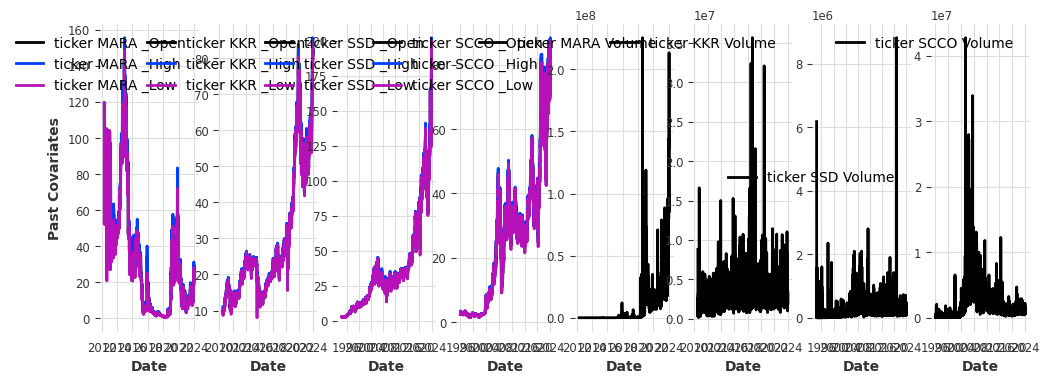

In [205]:
import matplotlib.pyplot as plt


n_plot_samples = 4
# plot sample of past covariates
fig, axes = plt.subplots(nrows=1, ncols=n_plot_samples*2, figsize=(12, 4))
for i,t in enumerate(past_covariates.keys()):
    if i < n_plot_samples:
        print(f'{t} past covariates components: {past_covariates[t].columns}')
        past_covariates[t].drop_columns(['Volume']).plot(label=f'ticker {t} ', ax=axes[i])
        past_covariates[t].univariate_component('Volume').plot(label=f'ticker {t} Volume ', ax=axes[n_plot_samples+i])

axes[0].set_ylabel('Past Covariates')


## Prepare Past Covariates

### Add sales and earnings calendar (past and forward looking) to past covariates
* Note: Research further if the data feed provides forward looking estimates at early enough dates to be seen by the model during training. It appears that some forward looking estimates are provided with a date column with value after the actual date they have become avaible.

In [206]:
import pandas as pd

earnings_loaded_df = pd.read_csv('data/earnings_calendar.csv.bz2')
print(earnings_loaded_df)

      symbol        date     eps  epsEstimated time       revenue  \
0       AAON  2024-11-04     NaN           NaN  amc           NaN   
1       AAON  2024-08-01     NaN           NaN  amc           NaN   
2       AAON  2024-05-02     NaN           NaN  amc           NaN   
3       AAON  2024-02-26     NaN          0.53  bmo           NaN   
4       AAON  2023-11-06  0.6400          0.55  amc  3.119700e+08   
...      ...         ...     ...           ...  ...           ...   
26172    ZTS  2012-03-31  0.2311           NaN  bmo  1.047000e+09   
26173    ZTS  2011-12-31  0.0180           NaN  bmo  1.127000e+09   
26174    ZTS  2011-09-30  0.1880           NaN  bmo  1.049000e+09   
26175    ZTS  2011-06-30  0.1320           NaN  bmo  1.074000e+09   
26176    ZTS  2011-03-31  0.1583           NaN  bmo  9.830000e+08   

       revenueEstimated updatedFromDate fiscalDateEnding  
0                   NaN      2024-01-13       2024-09-30  
1                   NaN      2024-01-13       2024-06

In [207]:
earnings_loaded_df.index.is_unique

True

In [208]:
earnings_loaded_df.index

RangeIndex(start=0, stop=26177, step=1)

In [209]:
len(earnings_loaded_df.index)

26177

In [210]:
earnings_loaded_df['date'] = pd.to_datetime(earnings_loaded_df['date'])

In [211]:
earnings_unique = earnings_loaded_df.drop_duplicates(subset=['symbol', 'date'])


In [212]:
assert not earnings_unique.duplicated().any()

In [213]:
earnings_unique

,symbol,date,eps,epsEstimated,time,revenue,revenueEstimated,updatedFromDate,fiscalDateEnding
0,AAON,2024-11-04,NaN,NaN,amc,NaN,NaN,2024-01-13,2024-09-30
1,AAON,2024-08-01,NaN,NaN,amc,NaN,NaN,2024-01-13,2024-06-30
2,AAON,2024-05-02,NaN,NaN,amc,NaN,NaN,2024-01-13,2024-03-30
3,AAON,2024-02-26,NaN,0.53,bmo,NaN,294360000.0,2024-01-13,2023-12-30
4,AAON,2023-11-06,0.6400,0.55,amc,3.119700e+08,294360000.0,2024-01-13,2023-09-30
...,...,...,...,...,...,...,...,...,...
26172,ZTS,2012-03-31,0.2311,NaN,bmo,1.047000e+09,NaN,2023-12-04,2012-03-31
26173,ZTS,2011-12-31,0.0180,NaN,bmo,1.127000e+09,NaN,2023-12-04,2011-12-31
26174,ZTS,2011-09-30,0.1880,NaN,bmo,1.049000e+09,NaN,2023-12-04,2011-09-30
26175,ZTS,2011-06-30,0.1320,NaN,bmo,1.074000e+09,NaN,2023-12-04,2011-06-30


In [214]:
earnings_unique = earnings_unique.set_index(keys=['symbol', 'date'])

In [215]:
earnings_unique

eps  epsEstimated time       revenue  revenueEstimated  \
symbol date                                                                    
AAON   2024-11-04     NaN           NaN  amc           NaN               NaN   
       2024-08-01     NaN           NaN  amc           NaN               NaN   
       2024-05-02     NaN           NaN  amc           NaN               NaN   
       2024-02-26     NaN          0.53  bmo           NaN       294360000.0   
       2023-11-06  0.6400          0.55  amc  3.119700e+08       294360000.0   
...                   ...           ...  ...           ...               ...   
ZTS    2012-03-31  0.2311           NaN  bmo  1.047000e+09               NaN   
       2011-12-31  0.0180           NaN  bmo  1.127000e+09               NaN   
       2011-09-30  0.1880           NaN  bmo  1.049000e+09               NaN   
       2011-06-30  0.1320           NaN  bmo  1.074000e+09               NaN   
       2011-03-31  0.1583           NaN  bmo  9.830000e+08               NaN   

                  updatedFromDate fiscalDateEnding  
symbol date                                         
AAON   2024-11-04      2024-01-13       2024-09-30  
       2024-08-01      2024-01-13       2024-06-30  
       2024-05-02      2024-01-13       2024-03-30  
       2024-02-26      2024-01-13       2023-12-30  
       2023-11-06      2024-01-13       2023-09-30  
...                           ...              ...  
ZTS    2012-03-31      2023-12-04       2012-03-31  
       2011-12-31      2023-12-04       2011-12-31  
       2011-09-30      2023-12-04       2011-09-30  
       2011-06-30      2023-12-04       2011-06-30  
       2011-03-31      2023-12-04       2011-03-31  

[26167 rows x 7 columns]

In [216]:
assert earnings_unique.index.has_duplicates == False

In [217]:
# check if data for a given symbol was saved and loaded as expected
earnings_unique.xs('LRN', level='symbol')

,eps,epsEstimated,time,revenue,revenueEstimated,updatedFromDate,fiscalDateEnding
date,,,,,,,
2024-10-22,NaN,NaN,amc,NaN,NaN,2024-01-13,2024-09-30
2024-08-13,NaN,NaN,amc,NaN,NaN,2024-01-13,2024-06-30
2024-04-23,NaN,NaN,amc,NaN,NaN,2024-01-13,2024-03-30
2024-01-23,NaN,1.34,amc,NaN,500850000.0,2024-01-13,2023-12-30
2023-10-24,0.11000,-0.35,amc,480181000.0,451150000.0,2024-01-13,2023-09-30
...,...,...,...,...,...,...,...
2006-06-30,0.17150,NaN,amc,29225000.0,NaN,2023-12-04,2006-06-30
2006-03-31,0.17200,NaN,amc,29226000.0,NaN,2023-12-04,2006-03-31
2005-12-31,0.17200,NaN,amc,29226000.0,NaN,2023-12-04,2005-12-31


In [218]:
print(earnings_unique.xs('LRN', level='symbol').head(n=20).to_string(index=True))

             eps  epsEstimated time      revenue  revenueEstimated updatedFromDate fiscalDateEnding
date                                                                                               
2024-10-22   NaN           NaN  amc          NaN               NaN      2024-01-13       2024-09-30
2024-08-13   NaN           NaN  amc          NaN               NaN      2024-01-13       2024-06-30
2024-04-23   NaN           NaN  amc          NaN               NaN      2024-01-13       2024-03-30
2024-01-23   NaN        1.3400  amc          NaN      5.008500e+08      2024-01-13       2023-12-30
2023-10-24  0.11       -0.3500  amc  480181000.0      4.511500e+08      2024-01-13       2023-09-30
2023-08-15  1.01        0.8700  amc  483489000.0      4.607000e+08      2023-12-04       2023-06-30
2023-04-25  1.30        1.0700  amc  470284000.0      4.607000e+08      2023-12-04       2023-03-31
2023-01-24  1.19        1.0400  amc  458435000.0               NaN      2023-12-04       2022-12-31


In [219]:
# get a clean deep copy so it is easier to debug further data cleanup steps
earnings_expanded_df = earnings_unique.copy()

In [220]:
# convert date strings to numerical representation
ufd = pd.to_datetime(earnings_expanded_df['updatedFromDate'])
ufd_year = ufd.dt.year
ufd_month = ufd.dt.month
ufd_day = ufd.dt.day

earn_n_cols = len(earnings_expanded_df.columns)
earnings_expanded_df.insert(loc=earn_n_cols, column='updatedFromDate_year', value=ufd_year)
earnings_expanded_df.insert(loc=earn_n_cols, column='updatedFromDate_month', value=ufd_month)
earnings_expanded_df.insert(loc=earn_n_cols, column='updatedFromDate_day', value=ufd_day)
earnings_expanded_df.pop('updatedFromDate')


symbol  date      
AAON    2024-11-04    2024-01-13
        2024-08-01    2024-01-13
        2024-05-02    2024-01-13
        2024-02-26    2024-01-13
        2023-11-06    2024-01-13
                         ...    
ZTS     2012-03-31    2023-12-04
        2011-12-31    2023-12-04
        2011-09-30    2023-12-04
        2011-06-30    2023-12-04
        2011-03-31    2023-12-04
Name: updatedFromDate, Length: 26167, dtype: object

In [221]:
print(earnings_expanded_df.xs('LRN', level='symbol').head(n=20).to_string(index=True))

             eps  epsEstimated time      revenue  revenueEstimated fiscalDateEnding  updatedFromDate_day  updatedFromDate_month  updatedFromDate_year
date                                                                                                                                                 
2024-10-22   NaN           NaN  amc          NaN               NaN       2024-09-30                   13                      1                  2024
2024-08-13   NaN           NaN  amc          NaN               NaN       2024-06-30                   13                      1                  2024
2024-04-23   NaN           NaN  amc          NaN               NaN       2024-03-30                   13                      1                  2024
2024-01-23   NaN        1.3400  amc          NaN      5.008500e+08       2023-12-30                   13                      1                  2024
2023-10-24  0.11       -0.3500  amc  480181000.0      4.511500e+08       2023-09-30                 

In [222]:
# convert date strings to numerical representation
fde = pd.to_datetime(earnings_expanded_df['fiscalDateEnding'])
fde_year = fde.dt.year
fde_month = fde.dt.month
fde_day = fde.dt.day

earn_n_cols = len(earnings_expanded_df.columns)
earnings_expanded_df.insert(loc=earn_n_cols, column='fiscalDateEnding_year', value=fde_year)
earnings_expanded_df.insert(loc=earn_n_cols, column='fiscalDateEnding_month', value=fde_month)
earnings_expanded_df.insert(loc=earn_n_cols, column='fiscalDateEnding_day', value=fde_day)
earnings_expanded_df.pop('fiscalDateEnding')


symbol  date      
AAON    2024-11-04    2024-09-30
        2024-08-01    2024-06-30
        2024-05-02    2024-03-30
        2024-02-26    2023-12-30
        2023-11-06    2023-09-30
                         ...    
ZTS     2012-03-31    2012-03-31
        2011-12-31    2011-12-31
        2011-09-30    2011-09-30
        2011-06-30    2011-06-30
        2011-03-31    2011-03-31
Name: fiscalDateEnding, Length: 26167, dtype: object

In [223]:
print(earnings_expanded_df.xs('LRN', level='symbol').head(n=20).to_string(index=True))

             eps  epsEstimated time      revenue  revenueEstimated  updatedFromDate_day  updatedFromDate_month  updatedFromDate_year  fiscalDateEnding_day  fiscalDateEnding_month  fiscalDateEnding_year
date                                                                                                                                                                                                     
2024-10-22   NaN           NaN  amc          NaN               NaN                   13                      1                  2024                    30                       9                   2024
2024-08-13   NaN           NaN  amc          NaN               NaN                   13                      1                  2024                    30                       6                   2024
2024-04-23   NaN           NaN  amc          NaN               NaN                   13                      1                  2024                    30                       3              

In [224]:
# convert earnings reporting time - Before Market Open / After Market Close - categories to numerical representation
earnings_expanded_df['time'] = earnings_expanded_df['time'].replace(['bmo', 'amc', '--'],
                        [0, 1, -1], inplace=False).astype('int32')



In [225]:
print(earnings_expanded_df.xs('LRN', level='symbol').head(n=20).to_string(index=True))

             eps  epsEstimated  time      revenue  revenueEstimated  updatedFromDate_day  updatedFromDate_month  updatedFromDate_year  fiscalDateEnding_day  fiscalDateEnding_month  fiscalDateEnding_year
date                                                                                                                                                                                                      
2024-10-22   NaN           NaN     1          NaN               NaN                   13                      1                  2024                    30                       9                   2024
2024-08-13   NaN           NaN     1          NaN               NaN                   13                      1                  2024                    30                       6                   2024
2024-04-23   NaN           NaN     1          NaN               NaN                   13                      1                  2024                    30                       3         

In [226]:
from darts import TimeSeries

type(earnings_expanded_df.index)

pandas.core.indexes.multi.MultiIndex

In [227]:
earnings_expanded_df.index.names

FrozenList(['symbol', 'date'])

In [228]:
earnings_expanded_df.dtypes

eps                       float64
epsEstimated              float64
time                        int32
revenue                   float64
revenueEstimated          float64
updatedFromDate_day         int32
updatedFromDate_month       int32
updatedFromDate_year        int32
fiscalDateEnding_day        int32
fiscalDateEnding_month      int32
fiscalDateEnding_year       int32
dtype: object

In [229]:
# credit for implementation: https://stackoverflow.com/a/39068260/12015435
def is_business_day(date):
    return bool(len(pd.bdate_range(date, date)))


In [230]:
t_earn = earnings_expanded_df.loc[['LRN']]
t_earn = t_earn.droplevel('symbol')
t_earn.index = pd.to_datetime(t_earn.index)
print(f'index type for {t}: {type(t_earn.index)}')
assert not t_earn.index.duplicated().any()

for i in t_earn.index:
    if not is_business_day(i):
        print(f'earnings record date is not a business day: \n{t_earn.loc[[i]]}')



index type for CRS: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
earnings record date is not a business day: 
               eps  epsEstimated  time     revenue  revenueEstimated  \
date                                                                   
2007-09-30  0.1201           NaN     1  27196000.0               NaN   

            updatedFromDate_day  updatedFromDate_month  updatedFromDate_year  \
date                                                                           
2007-09-30                    4                     12                  2023   

            fiscalDateEnding_day  fiscalDateEnding_month  \
date                                                       
2007-09-30                    30                       9   

            fiscalDateEnding_year  
date                               
2007-09-30                   2007  
earnings record date is not a business day: 
                eps  epsEstimated  time     revenue  revenueEstimated  \
date            

In [231]:
len(t_earn.index)

78

In [232]:
# align all dates with Business days
from pandas.tseries.offsets import BDay

def to_biz_day(date=None, report_time=None):
    if not is_business_day(date):
        if report_time == 1 or report_time =='amc':
                return date-BDay(n=1)
        else: 
            return date+BDay(n=1)
    else:
         return date

def align_to_business_days(t_earn=None):
    assert not t_earn.index.isnull().any()
    new_index = t_earn.index.map(lambda x : to_biz_day(date=x, report_time=t_earn.at[x, 'time']))
    t_earn.index = new_index
    if t_earn.index.isnull().any():
         print(t_earn[t_earn.index.isnull()])
    for i in t_earn.index:
        assert is_business_day(i)
    return t_earn


In [233]:
# backfill quarterly earnigs and revenue estimates so that the model can see the next quarter's estimates during the previou s quarter days

def back_fill_earn_estimates(t_earn=None):
    t_earn['time'].bfill(inplace=True)
    t_earn['epsEstimated'].bfill(inplace=True)
    t_earn['revenueEstimated'].bfill(inplace=True)
    t_earn['fiscalDateEnding_day'].bfill(inplace=True)
    t_earn['fiscalDateEnding_month'].bfill(inplace=True)
    t_earn['fiscalDateEnding_year'].bfill(inplace=True)
    return t_earn



In [234]:
# convert earnings dataframe to series

t_earn_series = {}
for t in list(ticker_series.keys()):
    print(f'ticker: {t}')
    t_earn = earnings_expanded_df.loc[[t]].copy()
    t_earn = t_earn.droplevel('symbol')
    t_earn.index = pd.to_datetime(t_earn.index)
    print(f'index type for {t}: {type(t_earn.index)}')
    assert not t_earn.index.duplicated().any()
    assert not t_earn.index.isnull().any()
    t_earn = align_to_business_days(t_earn)
    print(f't_earn freq: {t_earn.index}')
    tes_tmp = TimeSeries.from_dataframe(t_earn, freq='B', fill_missing_dates=True)
    t_earn = back_fill_earn_estimates(t_earn=tes_tmp.pd_dataframe())
    tes = TimeSeries.from_dataframe(t_earn, fillna_value=-1)
    assert len(tes.gaps()) == 0
    t_earn_series[t] = tes


ticker: MARA
index type for MARA: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
t_earn freq: DatetimeIndex(['2024-11-06', '2024-08-06', '2024-05-08', '2024-03-21',
               '2023-11-08', '2023-08-08', '2023-05-10', '2023-03-16',
               '2022-11-08', '2022-08-08', '2022-05-04', '2022-03-01',
               '2021-11-10', '2021-08-13', '2021-05-10', '2021-03-16',
               '2020-11-12', '2020-08-14', '2020-05-14', '2020-03-23',
               '2019-11-11', '2019-08-01', '2019-05-10', '2019-03-25',
               '2018-11-13', '2018-08-13', '2018-05-18', '2018-01-01',
               '2017-11-20', '2017-08-14', '2017-05-15', '2017-01-02',
               '2016-11-14', '2016-08-15', '2016-05-12', '2015-12-31',
               '2015-11-16', '2015-08-14', '2015-05-14', '2015-03-26',
               '2014-11-12', '2014-08-14', '2014-03-31', '2013-12-31',
               '2013-09-30', '2013-07-01', '2013-04-01', '2012-12-31',
               '2012-10-01', '2012-07-02', '201

In [235]:
t

'CRS'

In [236]:
t_earn


component,eps,epsEstimated,time,revenue,revenueEstimated,updatedFromDate_day,updatedFromDate_month,updatedFromDate_year,fiscalDateEnding_day,fiscalDateEnding_month,fiscalDateEnding_year
date,,,,,,,,,,,
1989-10-02,0.215,0.16,0.0,133600000.0,1.862348e+08,4.0,12.0,2023.0,30.0,9.0,1989.0
1989-10-03,NaN,0.16,0.0,NaN,1.862348e+08,NaN,NaN,NaN,31.0,12.0,1989.0
1989-10-04,NaN,0.16,0.0,NaN,1.862348e+08,NaN,NaN,NaN,31.0,12.0,1989.0
1989-10-05,NaN,0.16,0.0,NaN,1.862348e+08,NaN,NaN,NaN,31.0,12.0,1989.0
1989-10-06,NaN,0.16,0.0,NaN,1.862348e+08,NaN,NaN,NaN,31.0,12.0,1989.0
...,...,...,...,...,...,...,...,...,...,...,...
2024-10-18,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,30.0,9.0,2024.0
2024-10-21,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,30.0,9.0,2024.0
2024-10-22,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,30.0,9.0,2024.0


In [237]:
print(t_earn.tail(n=330).to_string(index=True))

component    eps  epsEstimated  time      revenue  revenueEstimated  updatedFromDate_day  updatedFromDate_month  updatedFromDate_year  fiscalDateEnding_day  fiscalDateEnding_month  fiscalDateEnding_year
date                                                                                                                                                                                                      
2023-07-21   NaN          0.66   0.0          NaN       743070000.0                  NaN                    NaN                   NaN                  30.0                     6.0                 2023.0
2023-07-24   NaN          0.66   0.0          NaN       743070000.0                  NaN                    NaN                   NaN                  30.0                     6.0                 2023.0
2023-07-25   NaN          0.66   0.0          NaN       743070000.0                  NaN                    NaN                   NaN                  30.0                     6.0         

In [238]:
t_earn.index

DatetimeIndex(['1989-10-02', '1989-10-03', '1989-10-04', '1989-10-05',
               '1989-10-06', '1989-10-09', '1989-10-10', '1989-10-11',
               '1989-10-12', '1989-10-13',
               ...
               '2024-10-11', '2024-10-14', '2024-10-15', '2024-10-16',
               '2024-10-17', '2024-10-18', '2024-10-21', '2024-10-22',
               '2024-10-23', '2024-10-24'],
              dtype='datetime64[ns]', name='date', length=9149, freq='B')

In [239]:
tes.pd_dataframe()

component,eps,epsEstimated,time,revenue,revenueEstimated,updatedFromDate_day,updatedFromDate_month,updatedFromDate_year,fiscalDateEnding_day,fiscalDateEnding_month,fiscalDateEnding_year
date,,,,,,,,,,,
1989-10-02,0.215,0.16,0.0,133600000.0,1.862348e+08,4.0,12.0,2023.0,30.0,9.0,1989.0
1989-10-03,-1.000,0.16,0.0,-1.0,1.862348e+08,-1.0,-1.0,-1.0,31.0,12.0,1989.0
1989-10-04,-1.000,0.16,0.0,-1.0,1.862348e+08,-1.0,-1.0,-1.0,31.0,12.0,1989.0
1989-10-05,-1.000,0.16,0.0,-1.0,1.862348e+08,-1.0,-1.0,-1.0,31.0,12.0,1989.0
1989-10-06,-1.000,0.16,0.0,-1.0,1.862348e+08,-1.0,-1.0,-1.0,31.0,12.0,1989.0
...,...,...,...,...,...,...,...,...,...,...,...
2024-10-18,-1.000,-1.00,0.0,-1.0,-1.000000e+00,-1.0,-1.0,-1.0,30.0,9.0,2024.0
2024-10-21,-1.000,-1.00,0.0,-1.0,-1.000000e+00,-1.0,-1.0,-1.0,30.0,9.0,2024.0
2024-10-22,-1.000,-1.00,0.0,-1.0,-1.000000e+00,-1.0,-1.0,-1.0,30.0,9.0,2024.0


In [240]:
t_earn_series

{'MARA': <TimeSeries (DataArray) (date: 3723, component: 11, sample: 1)>
 array([[[-1.800e-04],
         [-1.840e+00],
         [-1.000e+00],
         ...,
         [ 3.100e+01],
         [ 7.000e+00],
         [ 2.010e+03]],
 
        [[-1.000e+00],
         [-1.840e+00],
         [-1.000e+00],
         ...,
         [ 3.100e+01],
         [ 1.000e+00],
         [ 2.011e+03]],
 
        [[-1.000e+00],
         [-1.840e+00],
         [-1.000e+00],
         ...,
 ...
         ...,
         [ 3.000e+01],
         [ 9.000e+00],
         [ 2.024e+03]],
 
        [[-1.000e+00],
         [-1.000e+00],
         [ 1.000e+00],
         ...,
         [ 3.000e+01],
         [ 9.000e+00],
         [ 2.024e+03]],
 
        [[-1.000e+00],
         [-1.000e+00],
         [ 1.000e+00],
         ...,
         [ 3.000e+01],
         [ 9.000e+00],
         [ 2.024e+03]]])
 Coordinates:
   * date       (date) datetime64[ns] 2010-08-02 2010-08-03 ... 2024-11-06
   * component  (component) object 'eps' ... 

In [241]:
# stack sales and earnigns to past covariates
new_past_covs = {}

for t, covs in list(past_covariates.items()):
    print(f'stacking future covs for {t}')
    past_covs_sliced = covs.slice_intersect(t_earn_series[t])
    earn_sliced = t_earn_series[t].slice_intersect(past_covs_sliced)
    new_past_covs[t] = past_covs_sliced.stack(earn_sliced)
    print(f'past covariates for {t} including earnings calendar: \n{new_past_covs[t].components}')
    print(f'past covariates for {t} start time: {new_past_covs[t].start_time()}, end time: {new_past_covs[t].end_time()}')
    print(f'past covariates for {t} sample: \n{new_past_covs[t][0].pd_dataframe()}')



stacking future covs for MARA
past covariates for MARA including earnings calendar: 
Index(['Open', 'High', 'Low', 'Volume', 'eps', 'epsEstimated', 'time',
       'revenue', 'revenueEstimated', 'updatedFromDate_day',
       'updatedFromDate_month', 'updatedFromDate_year', 'fiscalDateEnding_day',
       'fiscalDateEnding_month', 'fiscalDateEnding_year'],
      dtype='object', name='component')
past covariates for MARA start time: 2012-05-04 00:00:00, end time: 2024-01-12 00:00:00
past covariates for MARA sample: 
component        Open        High        Low  Volume  eps  epsEstimated  time  \
Date                                                                            
2012-05-04  53.040001  119.599998  53.040001     6.0 -1.0         -1.84  -1.0   

component   revenue  revenueEstimated  updatedFromDate_day  \
Date                                                         
2012-05-04     -1.0      3.001429e+06                 -1.0   

component   updatedFromDate_month  updatedFromDate_

In [242]:
past_covariates = new_past_covs

In [243]:
t

'CRS'

In [244]:
past_covariates[t].start_time(), past_covariates[t].end_time()

(Timestamp('1991-01-01 00:00:00'), Timestamp('2024-01-12 00:00:00'))

In [245]:
print(f'past covariates with price and earnings sample: {past_covariates[t][0:5].pd_dataframe()}')


past covariates with price and earnings sample: component       Open      High       Low   Volume  eps  epsEstimated  time  \
Date                                                                         
1991-01-01  11.12500  11.21875  11.06250  22800.0 -1.0          0.16   0.0   
1991-01-02  11.25000  11.25000  11.18750   8000.0 -1.0          0.16   0.0   
1991-01-03  11.18750  11.25000  11.18750   5600.0 -1.0          0.16   0.0   
1991-01-04  11.21875  11.34375  11.21875  11600.0 -1.0          0.16   0.0   
1991-01-07  11.40625  11.46875  11.18750  47600.0 -1.0          0.16   0.0   

component   revenue  revenueEstimated  updatedFromDate_day  \
Date                                                         
1991-01-01     -1.0      1.862348e+08                 -1.0   
1991-01-02     -1.0      1.862348e+08                 -1.0   
1991-01-03     -1.0      1.862348e+08                 -1.0   
1991-01-04     -1.0      1.862348e+08                 -1.0   
1991-01-07     -1.0      1.862348

In [246]:
t_earn_series[t].start_time(), t_earn_series[t].end_time()

(Timestamp('1989-10-02 00:00:00'), Timestamp('2024-10-24 00:00:00'))

### Add key metrics to past covariates

In [247]:
kms_file = 'data/keymetrics_history.csv.bz2'


In [248]:
import pandas as pd

kms_loaded_df = pd.read_csv(kms_file)
print(kms_loaded_df)

      symbol        date  calendarYear period  revenuePerShare  \
0        SSD  2023-09-30          2023     Q3        13.593701   
1        SSD  2023-06-30          2023     Q2        14.005015   
2        SSD  2023-03-31          2023     Q1        12.542361   
3        SSD  2022-12-31          2022     Q4        11.172179   
4        SSD  2022-09-30          2022     Q3        12.932100   
...      ...         ...           ...    ...              ...   
25625   ARVN  2018-03-31          2018     Q1         0.198178   
25626   ARVN  2017-12-31          2017     Q4         0.124075   
25627   ARVN  2017-09-30          2017     Q3         0.080497   
25628   ARVN  2017-06-30          2017     Q2         0.879481   
25629   ARVN  2017-03-31          2017     Q1         0.879481   

       netIncomePerShare  operatingCashFlowPerShare  freeCashFlowPerShare  \
0               2.437630                   0.000000              0.000000   
1               2.512620                   4.553235  

In [249]:
assert kms_loaded_df.index.is_unique

In [250]:
kms_loaded_df.index

RangeIndex(start=0, stop=25630, step=1)

In [251]:
len(kms_loaded_df.index)

25630

In [252]:
kms_loaded_df['date'] = pd.to_datetime(kms_loaded_df['date'])

In [253]:
kms_unique = kms_loaded_df.drop_duplicates(subset=['symbol', 'date'])


In [254]:
assert not kms_unique.duplicated().any()

In [255]:
kms_unique

,symbol,date,calendarYear,period,revenuePerShare,netIncomePerShare,operatingCashFlowPerShare,freeCashFlowPerShare,cashPerShare,bookValuePerShare,...,averagePayables,averageInventory,daysSalesOutstanding,daysPayablesOutstanding,daysOfInventoryOnHand,receivablesTurnover,payablesTurnover,inventoryTurnover,roe,capexPerShare
0,SSD,2023-09-30,2023,Q3,13.593701,2.437630,0.000000,0.000000,13.380967,39.122911,...,96557000.0,513307500.0,54.483075,28.852564,152.776520,1.651889,3.119307,0.589096,0.062307,0.000000
1,SSD,2023-06-30,2023,Q2,14.005015,2.512620,4.553235,4.104197,9.561555,37.013101,...,96574500.0,549301000.0,58.423190,28.396751,151.541723,1.540484,3.169377,0.593896,0.067885,-0.449038
2,SSD,2023-03-31,2023,Q1,12.542361,2.064163,0.069420,-0.370805,5.926801,34.907510,...,96571500.0,566617000.0,57.202365,30.463712,184.259396,1.573362,2.954335,0.488442,0.059132,-0.440225
3,SSD,2022-12-31,2022,Q4,11.172179,1.353119,3.204571,2.602015,14.128629,33.370008,...,98243500.0,548410500.0,50.925231,32.024534,182.247652,1.767297,2.810345,0.493834,0.040549,-0.602556
4,SSD,2022-09-30,2022,Q3,12.932100,2.061126,2.918389,2.690842,7.223554,31.241796,...,105807000.0,539932000.0,54.366039,28.718926,157.216657,1.655445,3.133822,0.572458,0.065973,-0.227548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25625,ARVN,2018-03-31,2018,Q1,0.198178,-0.200194,0.930897,0.900092,5.435910,2.480791,...,1281630.5,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.080698,-0.030805
25626,ARVN,2017-12-31,2017,Q4,0.124075,-0.228056,1.358169,1.337208,1.889431,0.011860,...,NaN,NaN,911.109535,0.000000,0.000000,0.098781,0.000000,0.000000,-19.229780,-0.020961
25627,ARVN,2017-09-30,2017,Q3,0.080497,-0.308572,-0.358904,-0.358676,NaN,NaN,...,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000229
25628,ARVN,2017-06-30,2017,Q2,0.879481,-3.519372,-4.494133,-4.544222,NaN,NaN,...,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.050089


In [256]:
kms_unique = kms_unique.set_index(keys=['symbol', 'date'])

In [257]:
kms_unique

calendarYear period  revenuePerShare  netIncomePerShare  \
symbol date                                                                  
SSD    2023-09-30          2023     Q3        13.593701           2.437630   
       2023-06-30          2023     Q2        14.005015           2.512620   
       2023-03-31          2023     Q1        12.542361           2.064163   
       2022-12-31          2022     Q4        11.172179           1.353119   
       2022-09-30          2022     Q3        12.932100           2.061126   
...                         ...    ...              ...                ...   
ARVN   2018-03-31          2018     Q1         0.198178          -0.200194   
       2017-12-31          2017     Q4         0.124075          -0.228056   
       2017-09-30          2017     Q3         0.080497          -0.308572   
       2017-06-30          2017     Q2         0.879481          -3.519372   
       2017-03-31          2017     Q1         0.879481          -3.291460   

                   operatingCashFlowPerShare  freeCashFlowPerShare  \
symbol date                                                          
SSD    2023-09-30                   0.000000              0.000000   
       2023-06-30                   4.553235              4.104197   
       2023-03-31                   0.069420             -0.370805   
       2022-12-31                   3.204571              2.602015   
       2022-09-30                   2.918389              2.690842   
...                                      ...                   ...   
ARVN   2018-03-31                   0.930897              0.900092   
       2017-12-31                   1.358169              1.337208   
       2017-09-30                  -0.358904             -0.358676   
       2017-06-30                  -4.494133             -4.544222   
       2017-03-31                  -3.728831             -3.985769   

                   cashPerShare  bookValuePerShare  tangibleBookValuePerShare  \
symbol date                                                                     
SSD    2023-09-30     13.380967          39.122911                  19.441544   
       2023-06-30      9.561555          37.013101                  16.815604   
       2023-03-31      5.926801          34.907510                  14.563201   
       2022-12-31     14.128629          33.370008                  13.013107   
       2022-09-30      7.223554          31.241796                  12.590381   
...                         ...                ...                        ...   
ARVN   2018-03-31      5.435910           2.480791                   2.480791   
       2017-12-31      1.889431           0.011860                   0.011860   
       2017-09-30           NaN                NaN                        NaN   
       2017-06-30           NaN                NaN                        NaN   
       2017-03-31     18.738486          12.694176                   0.000000   

                   shareholdersEquityPerShare  ...  averagePayables  \
symbol date                                    ...                    
SSD    2023-09-30                   39.122911  ...       96557000.0   
       2023-06-30                   37.013101  ...       96574500.0   
       2023-03-31                   34.907510  ...       96571500.0   
       2022-12-31                   33.370008  ...       98243500.0   
       2022-09-30                   31.241796  ...      105807000.0   
...                                       ...  ...              ...   
ARVN   2018-03-31                    2.480791  ...        1281630.5   
       2017-12-31                    0.011860  ...              NaN   
       2017-09-30                         NaN  ...              NaN   
       2017-06-30                         NaN  ...              NaN   
       2017-03-31                   12.694176  ...              NaN   

                   averageInventory  daysSalesOutstanding  \
symbol date                                           

In [258]:
assert kms_unique.index.has_duplicates == False

In [259]:
# check if data for a given symbol was saved and loaded as expected
kms_unique.xs('AAON', level='symbol')

,calendarYear,period,revenuePerShare,netIncomePerShare,operatingCashFlowPerShare,freeCashFlowPerShare,cashPerShare,bookValuePerShare,tangibleBookValuePerShare,shareholdersEquityPerShare,...,averagePayables,averageInventory,daysSalesOutstanding,daysPayablesOutstanding,daysOfInventoryOnHand,receivablesTurnover,payablesTurnover,inventoryTurnover,roe,capexPerShare
date,,,,,,,,,,,,,,,,,,,,,
2023-09-30,2023,Q3,3.831670,0.590502,0.579780,0.306244,0.002604,8.382388,6.616297,8.382388,...,31063500.0,214957500.0,53.489951,13.747147,98.568015,1.682559,6.546813,0.913075,0.070446,-0.273536
2023-06-30,2023,Q2,5.230073,0.841396,1.015175,0.431417,0.096458,12.158279,9.493209,12.158279,...,30885500.0,207493500.0,55.996084,15.262268,102.068138,1.607255,5.896895,0.881764,0.069204,-0.583757
2023-03-31,2023,Q1,4.958054,0.686309,0.089913,-0.449510,0.046886,11.361059,8.646772,11.361059,...,37537000.0,199259000.0,59.586468,14.091653,95.138798,1.510410,6.386760,0.945986,0.060409,-0.539424
2022-12-31,2022,Q4,4.775174,0.729561,0.335803,0.102519,0.102238,10.516606,7.768928,10.516606,...,47063000.0,187913500.0,50.306012,23.266158,101.697234,1.789051,3.868279,0.884980,0.069372,-0.233284
2022-09-30,2022,Q3,4.561503,0.516552,0.845985,0.576005,0.201898,9.849672,7.078250,9.849672,...,42401000.0,170444500.0,54.015952,24.716520,89.935937,1.666174,3.641289,1.000712,0.052444,-0.269980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991-03-31,1991,Q1,0.090495,-0.001588,0.014289,0.014289,-0.001588,0.025402,0.025402,0.025402,...,1450000.0,4950000.0,56.842105,21.600000,88.200000,1.583333,4.166667,1.020408,-0.062500,0.000000
1990-12-31,1990,Q4,0.118167,0.000000,0.007034,0.005627,0.005627,0.023915,0.023915,0.023915,...,2250000.0,5900000.0,50.357143,20.400000,60.000000,1.787234,4.411765,1.500000,0.000000,-0.001407
1990-09-30,1990,Q3,0.177603,0.007034,-0.015826,-0.024618,0.000000,0.029894,0.029894,0.029894,...,2750000.0,6500000.0,43.663366,31.898734,77.468354,2.061224,2.821429,1.161765,0.235294,-0.008792


In [260]:
kms_loaded_df = kms_unique.copy()

In [261]:
# convert earnings reporting time - Before Market Open / After Market Close - categories to numerical representation
kms_loaded_df['period'] = kms_loaded_df['period'].replace(['Q1', 'Q2', 'Q3', 'Q4'],
                        [1, 2, 3, 4], inplace=False).astype('int32')

In [262]:
kms_loaded_df

calendarYear  period  revenuePerShare  netIncomePerShare  \
symbol date                                                                   
SSD    2023-09-30          2023       3        13.593701           2.437630   
       2023-06-30          2023       2        14.005015           2.512620   
       2023-03-31          2023       1        12.542361           2.064163   
       2022-12-31          2022       4        11.172179           1.353119   
       2022-09-30          2022       3        12.932100           2.061126   
...                         ...     ...              ...                ...   
ARVN   2018-03-31          2018       1         0.198178          -0.200194   
       2017-12-31          2017       4         0.124075          -0.228056   
       2017-09-30          2017       3         0.080497          -0.308572   
       2017-06-30          2017       2         0.879481          -3.519372   
       2017-03-31          2017       1         0.879481          -3.291460   

                   operatingCashFlowPerShare  freeCashFlowPerShare  \
symbol date                                                          
SSD    2023-09-30                   0.000000              0.000000   
       2023-06-30                   4.553235              4.104197   
       2023-03-31                   0.069420             -0.370805   
       2022-12-31                   3.204571              2.602015   
       2022-09-30                   2.918389              2.690842   
...                                      ...                   ...   
ARVN   2018-03-31                   0.930897              0.900092   
       2017-12-31                   1.358169              1.337208   
       2017-09-30                  -0.358904             -0.358676   
       2017-06-30                  -4.494133             -4.544222   
       2017-03-31                  -3.728831             -3.985769   

                   cashPerShare  bookValuePerShare  tangibleBookValuePerShare  \
symbol date                                                                     
SSD    2023-09-30     13.380967          39.122911                  19.441544   
       2023-06-30      9.561555          37.013101                  16.815604   
       2023-03-31      5.926801          34.907510                  14.563201   
       2022-12-31     14.128629          33.370008                  13.013107   
       2022-09-30      7.223554          31.241796                  12.590381   
...                         ...                ...                        ...   
ARVN   2018-03-31      5.435910           2.480791                   2.480791   
       2017-12-31      1.889431           0.011860                   0.011860   
       2017-09-30           NaN                NaN                        NaN   
       2017-06-30           NaN                NaN                        NaN   
       2017-03-31     18.738486          12.694176                   0.000000   

                   shareholdersEquityPerShare  ...  averagePayables  \
symbol date                                    ...                    
SSD    2023-09-30                   39.122911  ...       96557000.0   
       2023-06-30                   37.013101  ...       96574500.0   
       2023-03-31                   34.907510  ...       96571500.0   
       2022-12-31                   33.370008  ...       98243500.0   
       2022-09-30                   31.241796  ...      105807000.0   
...                                       ...  ...              ...   
ARVN   2018-03-31                    2.480791  ...        1281630.5   
       2017-12-31                    0.011860  ...              NaN   
       2017-09-30                         NaN  ...              NaN   
       2017-06-30                         NaN  ...              NaN   
       2017-03-31                   12.694176  ...              NaN   

                   averageInventory  daysSalesOutstanding  \
symbol date                              

In [263]:
from darts import TimeSeries

type(kms_loaded_df.index)

pandas.core.indexes.multi.MultiIndex

In [264]:
kms_loaded_df.index.names

FrozenList(['symbol', 'date'])

In [265]:
kms_loaded_df.dtypes

calendarYear                                int64
period                                      int32
revenuePerShare                           float64
netIncomePerShare                         float64
operatingCashFlowPerShare                 float64
freeCashFlowPerShare                      float64
cashPerShare                              float64
bookValuePerShare                         float64
tangibleBookValuePerShare                 float64
shareholdersEquityPerShare                float64
interestDebtPerShare                      float64
marketCap                                 float64
enterpriseValue                           float64
peRatio                                   float64
priceToSalesRatio                         float64
pocfratio                                 float64
pfcfRatio                                 float64
pbRatio                                   float64
ptbRatio                                  float64
evToSales                                 float64


In [266]:
# forward fill key metrics until the next company update so that the model can use the most recent known metrics on each timeseries step instead of sparce quarterly points in time

def forward_fill_key_metrics(t_kms_df=None):
    # print(f't_kms_df NaNs: \n{len(t_kms_df.isna())}')
    # print('t_kms_df before ffill', t_kms_df)
    t_kms_df.ffill(inplace=True)
    # print('t_kms_df after ffill', t_kms_df)
    # print(f't_kms_df NaNs: \n{len(t_kms_df.isna())}')
    # print(t_kms_df[t_kms_df.isna()])
    return t_kms_df



In [267]:
def kms_to_biz_days(t_kms_df=None):
    new_index = t_kms_df.index.map(lambda x : to_biz_day(date=x, report_time='bmo'))
    t_kms_df.index = new_index
    return t_kms_df



In [268]:

def pad_kms(kms_series=None, price_series=None):
    """ 
    Pad a ticker's key metrics to align with price data
    """
    updated_kms_series = None
    if kms_series.end_time() < price_series.end_time():
        print(f'ticker {t} kms end time is before ticker price series end time: {kms_series.end_time()} < {price_series.end_time()}')
        tkms_df = kms_series.pd_dataframe()
        new_kms_df = tkms_df.reindex(price_series.pd_dataframe().index, method='ffill', copy=True)
        new_kms_ser = TimeSeries.from_dataframe(new_kms_df, freq='B', fillna_value=-1)
        print(f'ticker {t} kms end time after reindex: {new_kms_ser.end_time()}')
        updated_kms_series = new_kms_ser
    else:
        updated_kms_series = kms_series
    if kms_series.start_time() > price_series.start_time():
        print(f'ticker {t} kms start time is after ticker price series start time: {kms_series.start_time()} > {price_series.start_time()}')
    return updated_kms_series



In [269]:
t_kms_series = {}
for t in list(ticker_series.keys()):
    print(f'ticker {t}')
    kms_df = kms_loaded_df.loc[[t]].copy()
    print(f'ticker_series[{t}] start time, end time: {ticker_series[t].start_time()}, {ticker_series[t].end_time()}')
    print(f'kms_ser_df start time, end time: {kms_df.index[0]}, {kms_df.index[-1]}')
    kms_df = kms_df.droplevel('symbol')
    kms_df.index = pd.to_datetime(kms_df.index)
    # print(f'index type for {t}: {type(t_kms.index)}')
    assert not kms_df.index.duplicated().any()
    # print(f'{t} earnings: \n{t_kms.columns}')
    kms_df = kms_to_biz_days(kms_df)
    tkms_series_tmp = TimeSeries.from_dataframe(kms_df, freq='B', fill_missing_dates=True)
    print(f'kms_series_tmp start time, end time: {tkms_series_tmp.start_time()}, {tkms_series_tmp.end_time()}')
    kms_df_ext =tkms_series_tmp.pd_dataframe()
    kms_df_ext = forward_fill_key_metrics(kms_df_ext)
    kms_ser = TimeSeries.from_dataframe(kms_df, freq='B', fillna_value=-1)
    kms_ser_padded = pad_kms(kms_series=kms_ser, price_series=ticker_series[t])
    print(f'kms_ser_padded start time, end time: {kms_ser_padded.start_time()}, {kms_ser_padded.end_time()}')
    assert len(kms_ser_padded.gaps()) == 0, f'found gaps in tmks series: \n{kms_ser_padded.gaps()}'
    t_kms_series[t] = kms_ser_padded


ticker MARA
ticker_series[MARA] start time, end time: 2012-05-04 00:00:00, 2024-01-12 00:00:00
kms_ser_df start time, end time: ('MARA', Timestamp('2023-09-30 00:00:00')), ('MARA', Timestamp('2010-07-31 00:00:00'))
kms_series_tmp start time, end time: 2010-08-02 00:00:00, 2023-10-02 00:00:00
ticker MARA kms end time is before ticker price series end time: 2023-10-02 00:00:00 < 2024-01-12 00:00:00
ticker MARA kms end time after reindex: 2024-01-12 00:00:00
kms_ser_padded start time, end time: 2012-05-04 00:00:00, 2024-01-12 00:00:00
ticker KKR
ticker_series[KKR] start time, end time: 2010-07-15 00:00:00, 2024-01-12 00:00:00
kms_ser_df start time, end time: ('KKR', Timestamp('2023-09-30 00:00:00')), ('KKR', Timestamp('2009-03-31 00:00:00'))
kms_series_tmp start time, end time: 2009-03-31 00:00:00, 2023-10-02 00:00:00
ticker KKR kms end time is before ticker price series end time: 2023-10-02 00:00:00 < 2024-01-12 00:00:00
ticker KKR kms end time after reindex: 2024-01-12 00:00:00
kms_ser_

In [270]:
t_kms_series

{'MARA': <TimeSeries (DataArray) (Date: 3051, component: 59, sample: 1)>
 array([[[-1.00000000e+00],
         [-1.00000000e+00],
         [-1.00000000e+00],
         ...,
         [-1.00000000e+00],
         [-1.00000000e+00],
         [-1.00000000e+00]],
 
        [[-1.00000000e+00],
         [-1.00000000e+00],
         [-1.00000000e+00],
         ...,
         [-1.00000000e+00],
         [-1.00000000e+00],
         [-1.00000000e+00]],
 
        [[-1.00000000e+00],
         [-1.00000000e+00],
         [-1.00000000e+00],
         ...,
 ...
         ...,
         [ 8.39358108e+00],
         [ 6.28823093e-02],
         [-1.39029073e-02]],
 
        [[ 2.02300000e+03],
         [ 3.00000000e+00],
         [ 5.44808001e-01],
         ...,
         [ 8.39358108e+00],
         [ 6.28823093e-02],
         [-1.39029073e-02]],
 
        [[ 2.02300000e+03],
         [ 3.00000000e+00],
         [ 5.44808001e-01],
         ...,
         [ 8.39358108e+00],
         [ 6.28823093e-02],
         [-1.3

In [271]:
t

'CRS'

In [272]:
kms_df

,calendarYear,period,revenuePerShare,netIncomePerShare,operatingCashFlowPerShare,freeCashFlowPerShare,cashPerShare,bookValuePerShare,tangibleBookValuePerShare,shareholdersEquityPerShare,...,averagePayables,averageInventory,daysSalesOutstanding,daysPayablesOutstanding,daysOfInventoryOnHand,receivablesTurnover,payablesTurnover,inventoryTurnover,roe,capexPerShare
date,,,,,,,,,,,,,,,,,,,,,
2023-10-02,2024,1,13.250000,0.892276,0.150407,-0.296748,0.367886,29.050813,23.599593,29.050813,...,296800000.0,673200000.0,70.520018,53.798787,120.505873,1.276233,1.672900,0.746852,0.030714,-0.447154
2023-06-30,2023,4,15.503067,0.785276,3.576687,2.946830,0.910020,28.550102,23.026585,28.550102,...,283050000.0,675050000.0,63.074792,39.162885,90.084494,1.426877,2.298094,0.999062,0.027505,-0.629857
2023-03-31,2023,3,14.141393,0.381148,0.088115,-0.331967,0.456967,27.196721,21.631148,27.196721,...,296350000.0,716550000.0,67.229387,43.446195,107.167281,1.338700,2.071528,0.839809,0.014014,-0.420082
2023-01-02,2023,2,11.866803,0.127049,-1.772541,-2.131148,0.409836,27.071721,21.475410,27.071721,...,296350000.0,669400000.0,68.630634,53.865645,127.760754,1.311368,1.670824,0.704442,0.004693,-0.358607
2022-09-30,2023,1,10.737166,-0.141684,-1.601643,-1.878850,1.080082,26.833676,21.203285,26.833676,...,265050000.0,556100000.0,67.160069,55.372784,118.455458,1.340082,1.625347,0.759779,-0.005280,-0.277207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1986-09-30,1987,1,3.256407,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
1986-06-30,1986,4,3.787795,0.000000,NaN,NaN,0.216763,8.670520,8.670520,8.670520,...,NaN,NaN,49.787234,0.000000,0.000000,1.807692,0.000000,0.000000,0.000000,NaN
1986-03-31,1986,3,3.937861,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN


In [273]:
kms_ser_padded.pd_dataframe()

component,calendarYear,period,revenuePerShare,netIncomePerShare,operatingCashFlowPerShare,freeCashFlowPerShare,cashPerShare,bookValuePerShare,tangibleBookValuePerShare,shareholdersEquityPerShare,...,averagePayables,averageInventory,daysSalesOutstanding,daysPayablesOutstanding,daysOfInventoryOnHand,receivablesTurnover,payablesTurnover,inventoryTurnover,roe,capexPerShare
Date,,,,,,,,,,,,,,,,,,,,,
1991-01-01,-1.0,-1.0,-1.00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0000,-1.000000,-1.000000,-1.000000
1991-01-02,-1.0,-1.0,-1.00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0000,-1.000000,-1.000000,-1.000000
1991-01-03,-1.0,-1.0,-1.00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0000,-1.000000,-1.000000,-1.000000
1991-01-04,-1.0,-1.0,-1.00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0000,-1.000000,-1.000000,-1.000000
1991-01-07,-1.0,-1.0,-1.00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0000,-1.000000,-1.000000,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-08,2024.0,1.0,13.25,0.892276,0.150407,-0.296748,0.367886,29.050813,23.599593,29.050813,...,296800000.0,673200000.0,70.520018,53.798787,120.505873,1.276233,1.6729,0.746852,0.030714,-0.447154
2024-01-09,2024.0,1.0,13.25,0.892276,0.150407,-0.296748,0.367886,29.050813,23.599593,29.050813,...,296800000.0,673200000.0,70.520018,53.798787,120.505873,1.276233,1.6729,0.746852,0.030714,-0.447154
2024-01-10,2024.0,1.0,13.25,0.892276,0.150407,-0.296748,0.367886,29.050813,23.599593,29.050813,...,296800000.0,673200000.0,70.520018,53.798787,120.505873,1.276233,1.6729,0.746852,0.030714,-0.447154


In [274]:
kms_ser_padded.pd_dataframe()

component,calendarYear,period,revenuePerShare,netIncomePerShare,operatingCashFlowPerShare,freeCashFlowPerShare,cashPerShare,bookValuePerShare,tangibleBookValuePerShare,shareholdersEquityPerShare,...,averagePayables,averageInventory,daysSalesOutstanding,daysPayablesOutstanding,daysOfInventoryOnHand,receivablesTurnover,payablesTurnover,inventoryTurnover,roe,capexPerShare
Date,,,,,,,,,,,,,,,,,,,,,
1991-01-01,-1.0,-1.0,-1.00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0000,-1.000000,-1.000000,-1.000000
1991-01-02,-1.0,-1.0,-1.00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0000,-1.000000,-1.000000,-1.000000
1991-01-03,-1.0,-1.0,-1.00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0000,-1.000000,-1.000000,-1.000000
1991-01-04,-1.0,-1.0,-1.00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0000,-1.000000,-1.000000,-1.000000
1991-01-07,-1.0,-1.0,-1.00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0000,-1.000000,-1.000000,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-08,2024.0,1.0,13.25,0.892276,0.150407,-0.296748,0.367886,29.050813,23.599593,29.050813,...,296800000.0,673200000.0,70.520018,53.798787,120.505873,1.276233,1.6729,0.746852,0.030714,-0.447154
2024-01-09,2024.0,1.0,13.25,0.892276,0.150407,-0.296748,0.367886,29.050813,23.599593,29.050813,...,296800000.0,673200000.0,70.520018,53.798787,120.505873,1.276233,1.6729,0.746852,0.030714,-0.447154
2024-01-10,2024.0,1.0,13.25,0.892276,0.150407,-0.296748,0.367886,29.050813,23.599593,29.050813,...,296800000.0,673200000.0,70.520018,53.798787,120.505873,1.276233,1.6729,0.746852,0.030714,-0.447154


In [275]:
# for c in kms_ser_padded.columns:
#    if len(kms_ser_padded[c].gaps()) > 0:
#        print(f'{c} NaNs: {len(kms_ser_padded[c].gaps())}')
#        print(kms_ser_padded[c].gaps())




In [276]:
# stack key metrics to past covariates
new_past_covs = {}

for t, covs in list(past_covariates.items()):
    print(f'stacking kms covs for {t}')
    past_covs_sliced = covs.slice_intersect(t_kms_series[t])
    kms_sliced = t_kms_series[t].slice_intersect(past_covs_sliced)
    new_past_covs[t] = past_covs_sliced.stack(kms_sliced)
    print(f'past covariates for {t} including key metrics: \n{new_past_covs[t].components}')
    print(f'past covariates for {t} start time: {new_past_covs[t].start_time()}, end time: {new_past_covs[t].end_time()}')
    # print(f'past covariates for {t} sample: \n{new_past_covs[t][0].pd_dataframe()}')



stacking kms covs for MARA
past covariates for MARA including key metrics: 
Index(['Open', 'High', 'Low', 'Volume', 'eps', 'epsEstimated', 'time',
       'revenue', 'revenueEstimated', 'updatedFromDate_day',
       'updatedFromDate_month', 'updatedFromDate_year', 'fiscalDateEnding_day',
       'fiscalDateEnding_month', 'fiscalDateEnding_year', 'calendarYear',
       'period', 'revenuePerShare', 'netIncomePerShare',
       'operatingCashFlowPerShare', 'freeCashFlowPerShare', 'cashPerShare',
       'bookValuePerShare', 'tangibleBookValuePerShare',
       'shareholdersEquityPerShare', 'interestDebtPerShare', 'marketCap',
       'enterpriseValue', 'peRatio', 'priceToSalesRatio', 'pocfratio',
       'pfcfRatio', 'pbRatio', 'ptbRatio', 'evToSales',
       'enterpriseValueOverEBITDA', 'evToOperatingCashFlow',
       'evToFreeCashFlow', 'earningsYield', 'freeCashFlowYield',
       'debtToEquity', 'debtToAssets', 'netDebtToEBITDA', 'currentRatio',
       'interestCoverage', 'incomeQuality', 'di

In [277]:
past_covariates = new_past_covs

In [278]:
t

'CRS'

In [279]:
past_covariates[t].start_time(), past_covariates[t].end_time()

(Timestamp('1991-01-01 00:00:00'), Timestamp('2024-01-12 00:00:00'))

In [280]:
print(f'past covariates with key metrics sample: \n{past_covariates[t][0:5].pd_dataframe()}')


past covariates with key metrics sample: 
component       Open      High       Low   Volume  eps  epsEstimated  time  \
Date                                                                         
1991-01-01  11.12500  11.21875  11.06250  22800.0 -1.0          0.16   0.0   
1991-01-02  11.25000  11.25000  11.18750   8000.0 -1.0          0.16   0.0   
1991-01-03  11.18750  11.25000  11.18750   5600.0 -1.0          0.16   0.0   
1991-01-04  11.21875  11.34375  11.21875  11600.0 -1.0          0.16   0.0   
1991-01-07  11.40625  11.46875  11.18750  47600.0 -1.0          0.16   0.0   

component   revenue  revenueEstimated  updatedFromDate_day  ...  \
Date                                                        ...   
1991-01-01     -1.0      1.862348e+08                 -1.0  ...   
1991-01-02     -1.0      1.862348e+08                 -1.0  ...   
1991-01-03     -1.0      1.862348e+08                 -1.0  ...   
1991-01-04     -1.0      1.862348e+08                 -1.0  ...   
1991-01-0

In [281]:
t_kms_series[t].start_time(), t_kms_series[t].end_time()

(Timestamp('1991-01-01 00:00:00'), Timestamp('2024-01-12 00:00:00'))

### Add broad market indicators to past covariates

In [282]:
broad_market_df = pd.read_csv('data/broad_market.csv.bz2', header=[0, 1], index_col=0)

# drop Close as redundand
broad_market_df = broad_market_df.drop(columns=['Close'], level=1)

# use a subset of indicies for testing
# broad_market_df = broad_market_df[(broad_market_df.columns[:1])]

#flatten column hierarchy so Darts can use as covariate series
broad_market_df.columns = [f'{i}_{j}' for i, j in broad_market_df.columns]

# CBOE VIX volatility, DYX USD and TNT 10Y Treasury indices do not have meaningful values for Volume
broad_market_df = broad_market_df.drop(columns=['^VIX_Volume', 'DX-Y.NYB_Volume', '^TNX_Volume'])

# fix datetime index type issue
# https://stackoverflow.com/questions/48248239/pandas-how-to-convert-rangeindex-into-datetimeindex
broad_market_df.index = pd.to_datetime(broad_market_df.index)

broad_market_df

,^R2ESC_Open,^R2ESC_High,^R2ESC_Low,^R2ESC_Adj Close,^R2ESC_Volume,^SPXEW_Open,^SPXEW_High,^SPXEW_Low,^SPXEW_Adj Close,^SPXEW_Volume,...,^TNX_Adj Close,^SPX_Open,^SPX_High,^SPX_Low,^SPX_Adj Close,^SPX_Volume,DX-Y.NYB_Open,DX-Y.NYB_High,DX-Y.NYB_Low,DX-Y.NYB_Adj Close
Date,,,,,,,,,,,,,,,,,,,,,
1927-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,17.660000,17.660000,17.660000,17.660000,0.000000e+00,NaN,NaN,NaN,NaN
1928-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,17.760000,17.760000,17.760000,17.760000,0.000000e+00,NaN,NaN,NaN,NaN
1928-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,17.719999,17.719999,17.719999,17.719999,0.000000e+00,NaN,NaN,NaN,NaN
1928-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,17.549999,17.549999,17.549999,17.549999,0.000000e+00,NaN,NaN,NaN,NaN
1928-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,17.660000,17.660000,17.660000,17.660000,0.000000e+00,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-08,NaN,NaN,NaN,NaN,NaN,6317.479980,6385.899902,6303.459961,6385.000000,0.0,...,4.002,4703.700195,4764.540039,4699.819824,4763.540039,3.742320e+09,102.440002,102.620003,102.080002,102.209999
2024-01-09,NaN,NaN,NaN,NaN,NaN,6384.660156,6384.660156,6334.509766,6354.080078,0.0,...,4.019,4741.930176,4765.470215,4730.350098,4756.500000,3.529960e+09,102.220001,102.660004,102.110001,102.570000
2024-01-10,NaN,NaN,NaN,NaN,NaN,6354.080078,6375.089844,6333.399902,6364.049805,0.0,...,4.030,4759.939941,4790.799805,4756.200195,4783.450195,3.498680e+09,102.480003,102.639999,102.339996,102.360001


In [283]:
broad_market_series = TimeSeries.from_dataframe(broad_market_df, freq='B')
broad_market_series = broad_market_series.slice(train_date_start, broad_market_series.end_time())
broad_market_series

<TimeSeries (DataArray) (Date: 8619, component: 42, sample: 1)>
array([[[          nan],
        [          nan],
        [          nan],
        ...,
        [  83.43000031],
        [  83.01000214],
        [  83.06999969]],

       [[          nan],
        [          nan],
        [          nan],
        ...,
        [  83.08000183],
        [  82.66000366],
        [  82.79000092]],

       [[          nan],
        [          nan],
        [          nan],
        ...,
...
        ...,
        [ 102.63999939],
        [ 102.33999634],
        [ 102.36000061]],

       [[          nan],
        [          nan],
        [          nan],
        ...,
        [ 102.76000214],
        [ 102.16000366],
        [ 102.29000092]],

       [[4247.75537109],
        [4324.00976562],
        [4239.99316406],
        ...,
        [ 102.58999634],
        [ 102.08999634],
        [ 102.40000153]]])
Coordinates:
  * Date       (Date) datetime64[ns] 1991-01-01 1991-01-02 ... 2024-01-12
  * component  (component) object '^R2ESC_Open' ... 'DX-Y.NYB_Adj Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [284]:
broad_market_series.gaps()


,gap_start,gap_end,gap_size
0,1999-04-02,1999-04-02,1
1,1999-05-31,1999-05-31,1
2,2000-04-21,2000-04-21,1
3,2000-05-29,2000-05-29,1
4,2000-09-04,2000-09-04,1
...,...,...,...
188,2023-07-04,2023-07-04,1
189,2023-09-04,2023-09-04,1
190,2023-11-23,2023-11-23,1
191,2023-12-25,2023-12-25,1


In [285]:

filler = MissingValuesFiller(n_jobs=-1)

series_filled = filler.transform(broad_market_series)
assert len(series_filled.gaps()) == 0

In [286]:
broad_market_series = series_filled


In [287]:
print(f'past covariates without broad market indicies: {past_covariates[t].components}')


past covariates without broad market indicies: Index(['Open', 'High', 'Low', 'Volume', 'eps', 'epsEstimated', 'time',
       'revenue', 'revenueEstimated', 'updatedFromDate_day',
       'updatedFromDate_month', 'updatedFromDate_year', 'fiscalDateEnding_day',
       'fiscalDateEnding_month', 'fiscalDateEnding_year', 'calendarYear',
       'period', 'revenuePerShare', 'netIncomePerShare',
       'operatingCashFlowPerShare', 'freeCashFlowPerShare', 'cashPerShare',
       'bookValuePerShare', 'tangibleBookValuePerShare',
       'shareholdersEquityPerShare', 'interestDebtPerShare', 'marketCap',
       'enterpriseValue', 'peRatio', 'priceToSalesRatio', 'pocfratio',
       'pfcfRatio', 'pbRatio', 'ptbRatio', 'evToSales',
       'enterpriseValueOverEBITDA', 'evToOperatingCashFlow',
       'evToFreeCashFlow', 'earningsYield', 'freeCashFlowYield',
       'debtToEquity', 'debtToAssets', 'netDebtToEBITDA', 'currentRatio',
       'interestCoverage', 'incomeQuality', 'dividendYield', 'payoutRatio',


In [288]:
print(f'past covariates without broad market indicies sample: {past_covariates[t][0:5].pd_dataframe()}')


past covariates without broad market indicies sample: component       Open      High       Low   Volume  eps  epsEstimated  time  \
Date                                                                         
1991-01-01  11.12500  11.21875  11.06250  22800.0 -1.0          0.16   0.0   
1991-01-02  11.25000  11.25000  11.18750   8000.0 -1.0          0.16   0.0   
1991-01-03  11.18750  11.25000  11.18750   5600.0 -1.0          0.16   0.0   
1991-01-04  11.21875  11.34375  11.21875  11600.0 -1.0          0.16   0.0   
1991-01-07  11.40625  11.46875  11.18750  47600.0 -1.0          0.16   0.0   

component   revenue  revenueEstimated  updatedFromDate_day  ...  \
Date                                                        ...   
1991-01-01     -1.0      1.862348e+08                 -1.0  ...   
1991-01-02     -1.0      1.862348e+08                 -1.0  ...   
1991-01-03     -1.0      1.862348e+08                 -1.0  ...   
1991-01-04     -1.0      1.862348e+08                 -1.0  ... 

In [289]:
for t, covs in past_covariates.items():
    bm_sliced = broad_market_series.slice_intersect(covs)
    past_covariates[t] = covs.stack(bm_sliced)
    # print(f'past covariates for {t} including broad market indicies: {past_covariates[t].components}')


In [290]:
print(f'past covariates with broad market indicies components: {past_covariates[t].components}')


past covariates with broad market indicies components: Index(['Open', 'High', 'Low', 'Volume', 'eps', 'epsEstimated', 'time',
       'revenue', 'revenueEstimated', 'updatedFromDate_day',
       ...
       '^TNX_Adj Close', '^SPX_Open', '^SPX_High', '^SPX_Low',
       '^SPX_Adj Close', '^SPX_Volume', 'DX-Y.NYB_Open', 'DX-Y.NYB_High',
       'DX-Y.NYB_Low', 'DX-Y.NYB_Adj Close'],
      dtype='object', name='component', length=116)


In [291]:
print(f'past covariates with broad market indicies sample: {past_covariates[t][0:5].pd_dataframe()}')


past covariates with broad market indicies sample: component       Open      High       Low   Volume  eps  epsEstimated  time  \
Date                                                                         
1991-01-01  11.12500  11.21875  11.06250  22800.0 -1.0          0.16   0.0   
1991-01-02  11.25000  11.25000  11.18750   8000.0 -1.0          0.16   0.0   
1991-01-03  11.18750  11.25000  11.18750   5600.0 -1.0          0.16   0.0   
1991-01-04  11.21875  11.34375  11.21875  11600.0 -1.0          0.16   0.0   
1991-01-07  11.40625  11.46875  11.18750  47600.0 -1.0          0.16   0.0   

component   revenue  revenueEstimated  updatedFromDate_day  ...  \
Date                                                        ...   
1991-01-01     -1.0      1.862348e+08                 -1.0  ...   
1991-01-02     -1.0      1.862348e+08                 -1.0  ...   
1991-01-03     -1.0      1.862348e+08                 -1.0  ...   
1991-01-04     -1.0      1.862348e+08                 -1.0  ...   


### Realign target series with past covariates

In [292]:
for t, covs in past_covariates.items():
    ts_sliced = target_series[t].slice_intersect(covs)
    target_series[t] = ts_sliced

In [293]:
# target_series['WRB'].pd_dataframe()

## Prepare Future Covariates

### Add holidays as future covariates

In [294]:

future_covariates = {t: ticker_series[t].univariate_component('holidays') for t in ticker_series.keys()}
future_covariates

{'MARA': <TimeSeries (DataArray) (Date: 3051, component: 1, sample: 1)>
 array([[[0.]],
 
        [[0.]],
 
        [[0.]],
 
        ...,
 
        [[0.]],
 
        [[0.]],
 
        [[0.]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 2012-05-04 2012-05-07 ... 2024-01-12
   * component  (component) object 'holidays'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None,
 'KKR': <TimeSeries (DataArray) (Date: 3522, component: 1, sample: 1)>
 array([[[0.]],
 
        [[0.]],
 
        [[0.]],
 
        ...,
 
        [[0.]],
 
        [[0.]],
 
        [[0.]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 2010-07-15 2010-07-16 ... 2024-01-12
   * component  (component) object 'holidays'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None,
 'SSD': <TimeSeries (DataArray) (Date: 7732, component: 1, sample: 1)>
 array([[[0.]],
 
        [[0.]],
 
        

### Add forward looking analyst estimates to future covariates

In [295]:
est_period = 'quarter'

In [296]:
est_file = f'data/analyst_estimates_{est_period}.csv.bz2'



In [297]:
import pandas as pd

est_loaded_df = pd.read_csv(est_file)
print(est_loaded_df)

      symbol        date  estimatedRevenueLow  estimatedRevenueHigh  \
0        SSD  2024-09-30           1124722349            1196284696   
1        SSD  2024-06-30            984132056            1046749109   
2        SSD  2024-03-30            843541762             897213522   
3        SSD  2023-12-30            469300000             499160000   
4        SSD  2023-09-30            548700000             567300000   
...      ...         ...                  ...                   ...   
19972   ARVN  2020-03-30              4312441               9212996   
19973   ARVN  2019-09-30             16512514              35276935   
19974   ARVN  2019-06-30              1884278               4025527   
19975   ARVN  2019-03-30              2590883               5535101   
19976   ARVN  2018-09-30              4839641              10339292   

       estimatedRevenueAvg  estimatedEbitdaLow  estimatedEbitdaHigh  \
0               1160168000         217287210.0          231112474.0   
1    

In [298]:
assert est_loaded_df.index.is_unique

In [299]:
est_loaded_df.index

RangeIndex(start=0, stop=19977, step=1)

In [300]:
len(est_loaded_df.index)

19977

In [301]:
est_loaded_df['date'] = pd.to_datetime(est_loaded_df['date'])

In [302]:
est_unique = est_loaded_df.drop_duplicates(subset=['symbol', 'date'])


In [303]:
assert not est_unique.duplicated().any()

In [304]:
est_unique

,symbol,date,estimatedRevenueLow,estimatedRevenueHigh,estimatedRevenueAvg,estimatedEbitdaLow,estimatedEbitdaHigh,estimatedEbitdaAvg,estimatedEbitLow,estimatedEbitHigh,...,estimatedNetIncomeHigh,estimatedNetIncomeAvg,estimatedSgaExpenseLow,estimatedSgaExpenseHigh,estimatedSgaExpenseAvg,estimatedEpsAvg,estimatedEpsHigh,estimatedEpsLow,numberAnalystEstimatedRevenue,numberAnalystsEstimatedEps
0,SSD,2024-09-30,1124722349,1196284696,1160168000,217287210.0,231112474.0,224135022.0,199979612.0,212703650.0,...,67010416.0,66098745.0,246440749.0,262120955.0,254207335.0,1.54141,1.56267,1.50420,4,1
1,SSD,2024-06-30,984132056,1046749109,1015147000,190126309.0,202223414.0,196118144.0,174982160.0,186115694.0,...,58367120.0,57572945.0,215635656.0,229355836.0,222431418.0,1.34259,1.36111,1.31018,3,2
2,SSD,2024-03-30,843541762,897213522,870126000,83669351.0,125504027.0,104586689.0,83669351.0,125504027.0,...,95386974.0,79489144.0,60924644.0,91386966.0,76155805.0,1.57645,1.59819,1.53840,4,3
3,SSD,2023-12-30,469300000,499160000,478857000,88644453.0,132966681.0,110805567.0,80905037.0,121357557.0,...,87269112.0,72724260.0,71150955.0,106726433.0,88938694.0,1.53000,1.53000,1.53000,4,2
4,SSD,2023-09-30,548700000,567300000,556620000,111755718.0,167633579.0,139694648.0,101251135.0,151876704.0,...,111362262.0,92801885.0,83375535.0,125063302.0,104219418.0,2.14000,2.25000,2.09000,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19972,ARVN,2020-03-30,4312441,9212996,6685315,-26797501.0,-17865000.0,-22331250.0,-29967440.0,-19978293.0,...,-18550759.0,-23188448.0,3574167.0,7635765.0,5540814.0,-0.59000,-0.16520,-1.18000,20,25
19973,ARVN,2019-09-30,16512514,35276935,25598341,-16895790.0,-11263860.0,-14079825.0,3637963.0,5456945.0,...,-11681116.0,-14601395.0,5258779.0,7888169.0,6573474.0,-0.31000,-0.08680,-0.62000,21,26
19974,ARVN,2019-06-30,1884278,4025527,2921082,-12483897.0,-8322598.0,-10403247.0,-13818696.0,-9212464.0,...,-8582323.0,-10727903.0,1561696.0,3336372.0,2421003.0,-0.46000,-0.12880,-0.92000,22,26
19975,ARVN,2019-03-30,2590883,5535101,4016489,-16745156.0,-11163437.0,-13954296.0,-18977398.0,-12651599.0,...,-11523593.0,-14404491.0,2147333.0,4587512.0,3328881.0,-0.47000,-0.13160,-0.94000,21,28


In [305]:
est_unique = est_unique.set_index(keys=['symbol', 'date'])

In [306]:
est_unique

estimatedRevenueLow  estimatedRevenueHigh  \
symbol date                                                    
SSD    2024-09-30           1124722349            1196284696   
       2024-06-30            984132056            1046749109   
       2024-03-30            843541762             897213522   
       2023-12-30            469300000             499160000   
       2023-09-30            548700000             567300000   
...                                ...                   ...   
ARVN   2020-03-30              4312441               9212996   
       2019-09-30             16512514              35276935   
       2019-06-30              1884278               4025527   
       2019-03-30              2590883               5535101   
       2018-09-30              4839641              10339292   

                   estimatedRevenueAvg  estimatedEbitdaLow  \
symbol date                                                  
SSD    2024-09-30           1160168000         217287210.0   
       2024-06-30           1015147000         190126309.0   
       2024-03-30            870126000          83669351.0   
       2023-12-30            478857000          88644453.0   
       2023-09-30            556620000         111755718.0   
...                                ...                 ...   
ARVN   2020-03-30              6685315         -26797501.0   
       2019-09-30             25598341         -16895790.0   
       2019-06-30              2921082         -12483897.0   
       2019-03-30              4016489         -16745156.0   
       2018-09-30              7502600         -35166398.0   

                   estimatedEbitdaHigh  estimatedEbitdaAvg  estimatedEbitLow  \
symbol date                                                                    
SSD    2024-09-30          231112474.0         224135022.0       199979612.0   
       2024-06-30          202223414.0         196118144.0       174982160.0   
       2024-03-30          125504027.0         104586689.0        83669351.0   
       2023-12-30          132966681.0         110805567.0        80905037.0   
       2023-09-30          167633579.0         139694648.0       101251135.0   
...                                ...                 ...               ...   
ARVN   2020-03-30          -17865000.0         -22331250.0       -29967440.0   
       2019-09-30          -11263860.0         -14079825.0         3637963.0   
       2019-06-30           -8322598.0         -10403247.0       -13818696.0   
       2019-03-30          -11163437.0         -13954296.0       -18977398.0   
       2018-09-30          -23444265.0         -29305331.0       -37500320.0   

                   estimatedEbitHigh  estimatedEbitAvg  estimatedNetIncomeLow  \
symbol date                                                                     
SSD    2024-09-30        212703650.0       206281974.0             64503105.0   
       2024-06-30        186115694.0       180496727.0             56183140.0   
       2024-03-30        125504027.0       104586689.0             63591315.0   
       2023-12-30        121357557.0       101131297.0             58179409.0   
       2023-09-30        151876704.0       126563919.0             74241508.0   
...                              ...               ...                    ...   
ARVN   2020-03-30        -19978293.0       -24972866.0            -27826138.0   
       2019-09-30          5456945.0         4547454.0            -17521674.0   
       2019-06-30         -9212464.0       -11515580.0            -12873484.0   
       2019-03-30        -12651599.0       -15814498.0            -17285390.0   
       2018-09-30        -25000213.0       -31250266.0            -35710042.0   

                   estimatedNetIncomeHigh  estimatedNetIncomeAvg  \
symbol date                                                        
SSD    2024-09-30              67010416.0             66098745.0   
       2024-06-30              58367120.0             57572945.0   
       2024-

In [307]:
assert est_unique.index.has_duplicates == False

In [308]:
# check if data for a given symbol was saved and loaded as expected
est_unique.xs('WRB', level='symbol')

,estimatedRevenueLow,estimatedRevenueHigh,estimatedRevenueAvg,estimatedEbitdaLow,estimatedEbitdaHigh,estimatedEbitdaAvg,estimatedEbitLow,estimatedEbitHigh,estimatedEbitAvg,estimatedNetIncomeLow,estimatedNetIncomeHigh,estimatedNetIncomeAvg,estimatedSgaExpenseLow,estimatedSgaExpenseHigh,estimatedSgaExpenseAvg,estimatedEpsAvg,estimatedEpsHigh,estimatedEpsLow,numberAnalystEstimatedRevenue,numberAnalystsEstimatedEps
date,,,,,,,,,,,,,,,,,,,,
2024-03-30,3090000000,3200000000,3140000000,258441867.0,387662800.0,323052333.0,287569317.0,297806413.0,292222542.0,162932145.0,244398220.0,203665182.0,0.0,0.0,0.0,1.40,1.430000,1.370000,2,4
2023-12-30,3160000000,3180000000,3170000000,319766284.0,479649426.0,399707855.0,294083832.0,295945123.0,295014478.0,223935044.0,335902567.0,279918805.0,0.0,0.0,0.0,1.29,1.420000,1.180000,3,7
2023-09-30,3041800000,3094300000,3069710000,253030681.0,379546021.0,316288351.0,283083608.0,287969495.0,285681038.0,168623661.0,252935493.0,210779577.0,0.0,0.0,0.0,1.18,1.220000,1.070000,5,12
2023-06-30,3038179817,3100304203,3068560000,283329062.0,424993593.0,354161327.0,282746698.0,288528273.0,285574014.0,179411237.0,269116855.0,224264046.0,0.0,0.0,0.0,1.10,1.179160,1.031760,6,12
2023-03-30,2834268819,2892223653,2862610000,234947152.0,352420728.0,293683940.0,263769822.0,269163360.0,266407380.0,148120132.0,222180200.0,185150166.0,0.0,0.0,0.0,1.23,1.318510,1.153700,12,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1997-12-30,283644444,425466666,354555555,44735680.0,67103520.0,55919600.0,26397229.0,39595844.0,32996536.0,21337360.0,32006040.0,26671700.0,0.0,0.0,0.0,0.11,0.130000,0.090000,11,11
1997-09-30,299307088,305427288,302300000,38480000.0,57720000.0,48100000.0,27854865.0,28424439.0,28133399.0,20480000.0,30720000.0,25600000.0,0.0,0.0,0.0,0.06,0.064318,0.056278,12,11
1997-06-30,323576903,330193370,326812500,35733333.0,53600000.0,44666666.0,30113524.0,30729282.0,30414643.0,18311111.0,27466666.0,22888888.0,0.0,0.0,0.0,0.06,0.064318,0.056278,10,11


In [309]:
est_loaded_df = est_unique.copy()

In [310]:
from darts import TimeSeries

type(est_loaded_df.index)

pandas.core.indexes.multi.MultiIndex

In [311]:
est_loaded_df.index.names

FrozenList(['symbol', 'date'])

In [312]:
est_loaded_df.dtypes

estimatedRevenueLow                int64
estimatedRevenueHigh               int64
estimatedRevenueAvg                int64
estimatedEbitdaLow               float64
estimatedEbitdaHigh              float64
estimatedEbitdaAvg               float64
estimatedEbitLow                 float64
estimatedEbitHigh                float64
estimatedEbitAvg                 float64
estimatedNetIncomeLow            float64
estimatedNetIncomeHigh           float64
estimatedNetIncomeAvg            float64
estimatedSgaExpenseLow           float64
estimatedSgaExpenseHigh          float64
estimatedSgaExpenseAvg           float64
estimatedEpsAvg                  float64
estimatedEpsHigh                 float64
estimatedEpsLow                  float64
numberAnalystEstimatedRevenue      int64
numberAnalystsEstimatedEps         int64
dtype: object

In [313]:
# forward fill key metrics until the next company update so that the model can use the most recent known metrics on each timeseries step instead of sparce quarterly points in time

def forward_fill_key_metrics(t_est_df=None):
    t_est_df.ffill(inplace=True)
    return t_est_df



In [314]:
def est_to_biz_days(t_est_df=None):
    new_index = t_est_df.index.map(lambda x : to_biz_day(date=x, report_time='bmo'))
    t_est_df.index = new_index
    return t_est_df



In [315]:

def prepare_est_series(t_est_df=None, n_future_periods=None):
    """
    Prepare future covariate series with analyst estimates for a given period (annual or quarter).
    :param n_future_periods: number of periods of future estimates to make visible at each timeseries date
    :return: estimate series expanded with forward periods at each series date indexed row
    """
    t_kms_series = {}
    for t in list(ticker_series.keys()):
        # print(f'ticker {t}')
        t_kms_df = kms_loaded_df.loc[[t]].copy()
        t_kms_df = t_kms_df.droplevel('symbol')
        t_kms_df.index = pd.to_datetime(t_kms_df.index)
        # print(f'index type for {t}: {type(t_kms.index)}')


        # expand series with future estimates per period 
        # https://pandas.pydata.org/docs/reference/api/pandas.Index.shift.html
        
        assert not t_kms_df.index.duplicated().any()
        # print(f'{t} earnings: \n{t_kms.columns}')
        t_kms_df = kms_to_biz_days(t_kms_df)
        tkms_series_tmp = TimeSeries.from_dataframe(t_kms_df, freq='B', fill_missing_dates=True)
        # print(f'tkms_series_tmp start time, end time: {tkms_series_tmp.start_time()}, {tkms_series_tmp.end_time()}')
        t_kms_df=tkms_series_tmp.pd_dataframe()
        t_kms_df = forward_fill_key_metrics(t_kms_df)
        tkms_ser = TimeSeries.from_dataframe(t_kms_df, freq='B', fillna_value=-1)
        assert len(tkms_ser.gaps()) == 0, f'found gaps in tmks series: \n{tkms_ser.gaps()}'
        t_kms_series[t] = tkms_ser


## Prepare train and validation splits

In [316]:
val_start = pd.Timestamp('2023-05-05')


In [317]:
# remove tickers that don't have sufficient training data
target_series_ok = {}

for t, target in target_series.items():
    # only include tickers with sufficient data for training
    if target.end_time() > val_start:
        target_series_ok[t] = target
    else:
        del past_covariates[t]
        del future_covariates[t]
        print(f'preparing train, val split for {t}')
        print(f'{t} is not OK. Filtering it out from target series. \n Reason: start time, end time, val_start: {target.start_time()}, {target.end_time()}, {val_start}')



In [318]:
target_series = target_series_ok

In [319]:
train_series = {}
val_series = {}
past_covariates_train = {}
past_covariates_val = {}

for t, target in target_series.items():
    print(f'preparing train, val split for {t}')
    print(f'{t} start time, end time: {target.start_time()}, {target.end_time()}')
    train, val = target.split_before(val_start)
    # there should be no gaps in the training data
    assert(len(train.gaps().index) == 0)
    train_series[t] = train
    val_series[t] = val
    past_train, past_val = past_covariates[t].split_before(val_start)
    # there should be no gaps in the training data
    assert(len(past_train.gaps().index) == 0)
    past_covariates_train[t] = past_train 
    past_covariates_val = past_val



preparing train, val split for MARA
MARA start time, end time: 2012-05-04 00:00:00, 2024-01-12 00:00:00
preparing train, val split for KKR
KKR start time, end time: 2010-07-15 00:00:00, 2024-01-12 00:00:00
preparing train, val split for SSD
SSD start time, end time: 1994-05-26 00:00:00, 2024-01-12 00:00:00
preparing train, val split for SCCO
SCCO start time, end time: 1996-01-05 00:00:00, 2024-01-12 00:00:00
preparing train, val split for PINS
PINS start time, end time: 2019-04-18 00:00:00, 2024-01-12 00:00:00
preparing train, val split for NBIX
NBIX start time, end time: 1996-07-31 00:00:00, 2024-01-12 00:00:00
preparing train, val split for SQ
SQ start time, end time: 2015-11-19 00:00:00, 2024-01-12 00:00:00
preparing train, val split for GOOG
GOOG start time, end time: 2004-08-19 00:00:00, 2024-01-12 00:00:00
preparing train, val split for AMD
AMD start time, end time: 1991-01-01 00:00:00, 2024-01-12 00:00:00
preparing train, val split for CRS
CRS start time, end time: 1991-01-01 00

In [320]:
train_series, val_series

({'MARA': <TimeSeries (DataArray) (Date: 2870, component: 1, sample: 1)>
  array([[[119.59999847]],
  
         [[119.59999847]],
  
         [[104.        ]],
  
         ...,
  
         [[  9.55000019]],
  
         [[  9.55000019]],
  
         [[ 10.27000046]]])
  Coordinates:
    * Date       (Date) datetime64[ns] 2012-05-04 2012-05-07 ... 2023-05-04
    * component  (component) object 'Adj Close'
  Dimensions without coordinates: sample
  Attributes:
      static_covariates:  None
      hierarchy:          None,
  'KKR': <TimeSeries (DataArray) (Date: 3341, component: 1, sample: 1)>
  array([[[ 5.92443228]],
  
         [[ 5.62821198]],
  
         [[ 5.6862936 ]],
  
         ...,
  
         [[50.78503418]],
  
         [[50.87427139]],
  
         [[49.17879105]]])
  Coordinates:
    * Date       (Date) datetime64[ns] 2010-07-15 2010-07-16 ... 2023-05-04
    * component  (component) object 'Adj Close'
  Dimensions without coordinates: sample
  Attributes:
      static_covaria

In [321]:
past_covariates_train, past_covariates_val

({'MARA': <TimeSeries (DataArray) (Date: 2870, component: 116, sample: 1)>
  array([[[ 53.04000092],
          [119.59999847],
          [ 53.04000092],
          ...,
          [ 79.51999664],
          [ 79.08000183],
          [ 79.47000122]],
  
         [[119.59999847],
          [119.59999847],
          [119.59999847],
          ...,
          [ 80.02999878],
          [ 79.5       ],
          [ 79.59999847]],
  
         [[ 53.04000092],
          [104.        ],
          [ 53.04000092],
          ...,
  ...
          ...,
          [102.40000153],
          [101.87999725],
          [101.95999908]],
  
         [[  9.17000008],
          [  9.97000027],
          [  9.09000015],
          ...,
          [101.91999817],
          [101.06999969],
          [101.33999634]],
  
         [[  9.73999977],
          [ 10.53999996],
          [  9.59000015],
          ...,
          [101.63999939],
          [101.02999878],
          [101.40000153]]])
  Coordinates:
    * Date      

Plot data splits

Text(0, 0.5, 'Target Series')

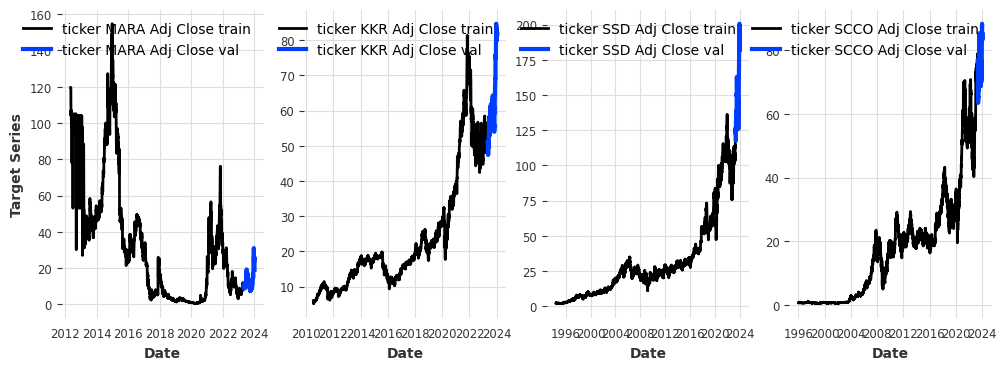

In [322]:
import matplotlib.pyplot as plt

# plot sample of target series
fig, axes = plt.subplots(nrows=1, ncols=n_plot_samples, figsize=(12, 4))
for i,t in enumerate(target_series.keys()):
    if i > n_plot_samples-1:
        break
    train_series[t].plot(label=f'ticker {t} {train_series[t].columns[0]} train', ax=axes[i])
    val_series[t].plot(label=f'ticker {t} {train_series[t].columns[0]} val', lw=3, ax=axes[i])

axes[0].set_ylabel('Target Series')


Show seasonalities

Text(0, 0.5, 'Seasonality')

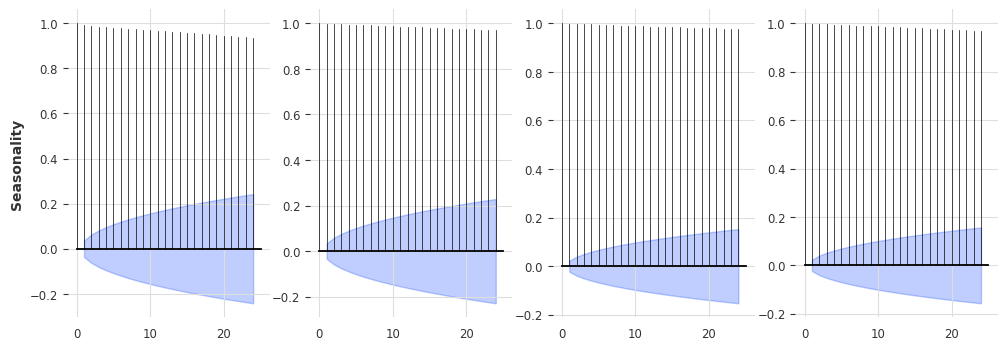

In [323]:
from darts.utils.statistics import plot_acf, check_seasonality

# plot sample of target series
fig, axes = plt.subplots(nrows=1, ncols=n_plot_samples, figsize=(12, 4))
for i,t in enumerate(target_series.keys()):
    if i >= n_plot_samples:
        break
    plot_acf(train_series[t], alpha=0.05, axis=axes[i])

axes[0].set_ylabel('Seasonality')



## Train our current working model

Prepare Encoders that Darts will automatically use for training and inference

In [324]:
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.dataprocessing import Pipeline
# 
# scaler = Scaler(verbose=True, n_jobs=-1)

# darts encoder examples: https://unit8co.github.io/darts/generated_api/darts.dataprocessing.encoders.encoders.html#
encoders = {
    'cyclic': {'future': ['dayofweek', 'month', 'quarter']},
    "datetime_attribute": {"future": ["dayofweek", "month", "quarter", "year"]}, 
    'position': {'past': ['relative'], 'future': ['relative']},
    'custom': {'future': [lambda idx: (idx.year % 4)]},  # signal proximity to US election years, which is known to have significance to market cycles.
    # "transformer": scaler
}



In [325]:
train_history = 252*2 # 252 days in a year with market data
pred_horizon = 21*2 # 21 days in a month with market data
n_epochs = 10 # model training epochs

Model hyperparameter selection

In [326]:
# based on Darts template: https://unit8co.github.io/darts/examples/18-TiDE-examples.html#Model-Parameter-Setup

optimizer_kwargs = {
    "lr": 1e-3,
}

# PyTorch Lightning Trainer arguments
pl_trainer_kwargs = {
    "gradient_clip_val": 1,
    "max_epochs": 200,
    "accelerator": "auto",
    "callbacks": [],
}

# learning rate scheduler
lr_scheduler_cls = torch.optim.lr_scheduler.ExponentialLR
lr_scheduler_kwargs = {
    "gamma": 0.999,
}

# early stopping (needs to be reset for each model later on)
# this setting stops training once the the validation loss has not decreased by more than 1e-3 for 10 epochs
early_stopping_args = {
    "monitor": "val_loss",
    "patience": 10,
    "min_delta": 1e-3,
    "mode": "min",
}

#
common_model_args = {
    # "input_chunk_length": 12,  # lookback window
    # "output_chunk_length": 12,  # forecast/lookahead window
    "optimizer_kwargs": optimizer_kwargs,
    "pl_trainer_kwargs": pl_trainer_kwargs,
    "lr_scheduler_cls": lr_scheduler_cls,
    "lr_scheduler_kwargs": lr_scheduler_kwargs,
    # "likelihood": None,  # use a likelihood for probabilistic forecasts
    # "save_checkpoints": True,  # checkpoint to retrieve the best performing model state,
    # "force_reset": True,
    "batch_size": 256,
    "random_state": 42,
}

In [327]:
from darts.models import TiDEModel

from darts.utils.likelihood_models import QuantileRegression

saved_model_name = 'data/canswim_model.pt'
model = None

# If available, load the saved model state that performed best on validation set
try:
  print('Loading saved model')
  model = TiDEModel.load(saved_model_name)  
except Exception as e:
  print('Error loading saved model:', e)
  print('Creating a new model')
  model = TiDEModel(
      **common_model_args,
      input_chunk_length=train_history,
      output_chunk_length=pred_horizon,
      use_layer_norm=True,
      add_encoders=None, # encoders,
      dropout=0.1,
      n_epochs=n_epochs,
      use_reversible_instance_norm=True,
      likelihood=QuantileRegression(quantiles=[0.01, 0.05, 0.2, 0.5, 0.8, 0.95, 0.99]),
      model_name=saved_model_name,
  )
  


Loading saved model


In [328]:
from darts.models import RegressionModel
from darts.models.forecasting.forecasting_model import GlobalForecastingModel

# when True, multiple time series are supported
supports_multi_ts = issubclass(model.__class__, GlobalForecastingModel)
supports_multi_ts

True

In [329]:
targets_list = [series for ticker, series in sorted(target_series.items())]
target_train_list = [series for ticker, series in sorted(train_series.items())]
print(len(target_train_list))
target_val_list = [series for ticker, series in sorted(val_series.items())]
print(len(target_train_list))
past_cov_list = [series for ticker, series in sorted(past_covariates_train.items())]
print(len(past_cov_list))
future_cov_list = [series for ticker, series in sorted(future_covariates.items())]
print(len(future_cov_list))


10
10
10
10


In [330]:
type(target_train_list[0])

darts.timeseries.TimeSeries

In [331]:
print(len(target_train_list[0].time_index))
print(len(past_cov_list[0].time_index))
print(len(future_cov_list[0].time_index))


8438
8438
8619


In [332]:
target_train_list[0].pd_dataframe()

component,Adj Close
Date,
1991-01-01,2.468750
1991-01-02,2.500000
1991-01-03,2.562500
1991-01-04,2.562500
1991-01-07,2.500000
...,...
2023-04-28,89.370003
2023-05-01,89.690002
2023-05-02,89.910004


In [333]:
target_train_list[0].start_time(), target_train_list[0].end_time()

(Timestamp('1991-01-01 00:00:00'), Timestamp('2023-05-04 00:00:00'))

In [334]:
past_cov_list[0].pd_dataframe().columns

Index(['Open', 'High', 'Low', 'Volume', 'eps', 'epsEstimated', 'time',
       'revenue', 'revenueEstimated', 'updatedFromDate_day',
       ...
       '^TNX_Adj Close', '^SPX_Open', '^SPX_High', '^SPX_Low',
       '^SPX_Adj Close', '^SPX_Volume', 'DX-Y.NYB_Open', 'DX-Y.NYB_High',
       'DX-Y.NYB_Low', 'DX-Y.NYB_Adj Close'],
      dtype='object', name='component', length=116)

In [335]:
past_cov_list[0].pd_dataframe()

component,Open,High,Low,Volume,eps,epsEstimated,time,revenue,revenueEstimated,updatedFromDate_day,...,^TNX_Adj Close,^SPX_Open,^SPX_High,^SPX_Low,^SPX_Adj Close,^SPX_Volume,DX-Y.NYB_Open,DX-Y.NYB_High,DX-Y.NYB_Low,DX-Y.NYB_Adj Close
Date,,,,,,,,,,,,,,,,,,,,,
1991-01-01,2.406250,2.531250,2.156250,601700.0,-1.0,0.31,1.0,-1.000000e+00,6.459700e+08,-1.0,...,7.970,330.200012,330.750000,326.450012,326.450012,1.262800e+08,83.370003,83.430000,83.010002,83.070000
1991-01-02,2.437500,2.625000,2.000000,522000.0,-1.0,0.31,1.0,-1.000000e+00,6.459700e+08,-1.0,...,7.970,330.200012,330.750000,326.450012,326.450012,1.262800e+08,82.930000,83.080002,82.660004,82.790001
1991-01-03,2.500000,2.625000,2.500000,973400.0,-1.0,0.31,1.0,-1.000000e+00,6.459700e+08,-1.0,...,7.930,326.459991,326.529999,321.899994,321.910004,1.414500e+08,82.889999,82.930000,82.680000,82.809998
1991-01-04,2.562500,2.562500,2.500000,328600.0,-1.0,0.31,1.0,-1.000000e+00,6.459700e+08,-1.0,...,8.020,321.910004,322.350006,318.869995,321.000000,1.408200e+08,82.669998,83.519997,82.599998,83.360001
1991-01-07,2.500000,2.562500,2.437500,437600.0,-1.0,0.31,1.0,-1.000000e+00,6.459700e+08,-1.0,...,8.130,320.970001,320.970001,315.440002,315.440002,1.306100e+08,84.870003,85.110001,84.540001,84.669998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-28,87.019997,89.750000,86.440002,50652100.0,-1.0,0.56,1.0,-1.000000e+00,5.299960e+09,-1.0,...,3.452,4129.629883,4170.060059,4127.180176,4169.479980,4.087800e+09,101.470001,102.169998,101.419998,101.669998
2023-05-01,91.029999,91.040001,88.610001,59358700.0,-1.0,0.56,1.0,-1.000000e+00,5.299960e+09,-1.0,...,3.574,4166.790039,4186.919922,4164.120117,4167.870117,3.321370e+09,101.669998,102.190002,101.620003,102.150002
2023-05-02,89.320000,90.459999,88.120003,70483500.0,0.6,0.56,1.0,5.353000e+09,5.299960e+09,4.0,...,3.439,4164.100098,4164.100098,4089.719971,4119.580078,4.486130e+09,102.150002,102.400002,101.879997,101.959999


In [336]:
past_cov_list[0].start_time(), past_cov_list[0].end_time()

(Timestamp('1991-01-01 00:00:00'), Timestamp('2023-05-04 00:00:00'))

In [337]:
n_holidays = future_cov_list[0].pd_dataframe().sum()
n_holidays

component
holidays    334.0
dtype: float64

In [338]:
future_cov_list[0].start_time(), future_cov_list[0].end_time()

(Timestamp('1991-01-01 00:00:00'), Timestamp('2024-01-12 00:00:00'))

In [339]:
# train model
# for i in range(100):
model.fit(target_train_list, epochs=n_epochs, past_covariates=past_cov_list, future_covariates=future_cov_list, verbose=True, num_loader_workers=10, )
          # val_series=target_val_list[0]) # , val_future_covariates=future_cov_list[0]) 



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name                  | Type             | Params
-----------------------------------------------------------
0 | criterion             | MSELoss          | 0     
1 | train_metrics         | MetricCollection | 0     
2 | val_metrics           | MetricCollection | 0     
3 | rin                   | RINorm           | 2     
4 | past_cov_projection   | _ResidualBlock   | 16.0 K
5 | future_cov_projection | _ResidualBlock   | 788   
6 | encoders              | Sequential       | 1.2 M 
7 | decoders              | Sequential       | 1.2 M 
8 | temporal_decoder      | _ResidualBlock   | 4.8 K 
9 | lookback_skip         | Linear           | 14

Training: |          | 0/? [00:00<?, ?it/s]

### Save model checkpoint

In [ ]:
# save model checkpoint
model.save(saved_model_name)


In [ ]:
# use probabilistic prediction
# see https://unit8co.github.io/darts/userguide/forecasting_overview.html#probabilistic-forecasts
pred = model.predict(pred_horizon, series=target_train_list, mc_dropout=True, num_samples=500, past_covariates=past_cov_list, future_covariates=future_cov_list)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

## Test Model Forecasting

In [ ]:
pred[0]

<TimeSeries (DataArray) (Date: 42, component: 1, sample: 500)>
array([[[76.9999264 , 77.06298393, 79.10636088, ..., 75.50427955,
         76.03723794, 77.77741615]],

       [[75.52191819, 75.51403047, 77.04734502, ..., 81.60439444,
         80.52517178, 79.50960742]],

       [[70.18981434, 69.94193573, 81.74697126, ..., 77.84782529,
         68.73216036, 79.00641908]],

       ...,

       [[81.3037934 , 76.30149958, 80.24436532, ..., 77.99326974,
         78.35217902, 82.10118861]],

       [[78.47518737, 79.87066004, 79.10259436, ..., 77.06888611,
         75.9864005 , 79.59629316]],

       [[79.39732251, 80.0089454 , 75.09947895, ..., 80.0869404 ,
         81.12219808, 79.81328779]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2023-05-05 2023-05-08 ... 2023-07-03
  * component  (component) object 'Adj Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [ ]:
pred[0].gaps()

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().


,gap_start,gap_end


In [ ]:
#pred2_series = target.slice(target.start_time(), val_start+pd.Timedelta(days=60))
#pred2 = model.predict(pred_horizon, series=pred2_series, past_covariates=past_covariates, future_covariates=future_covariates, mc_dropout=True, num_samples=500) #   len(val)) 
#pred2

### Plot several forecasts at various future starting points

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

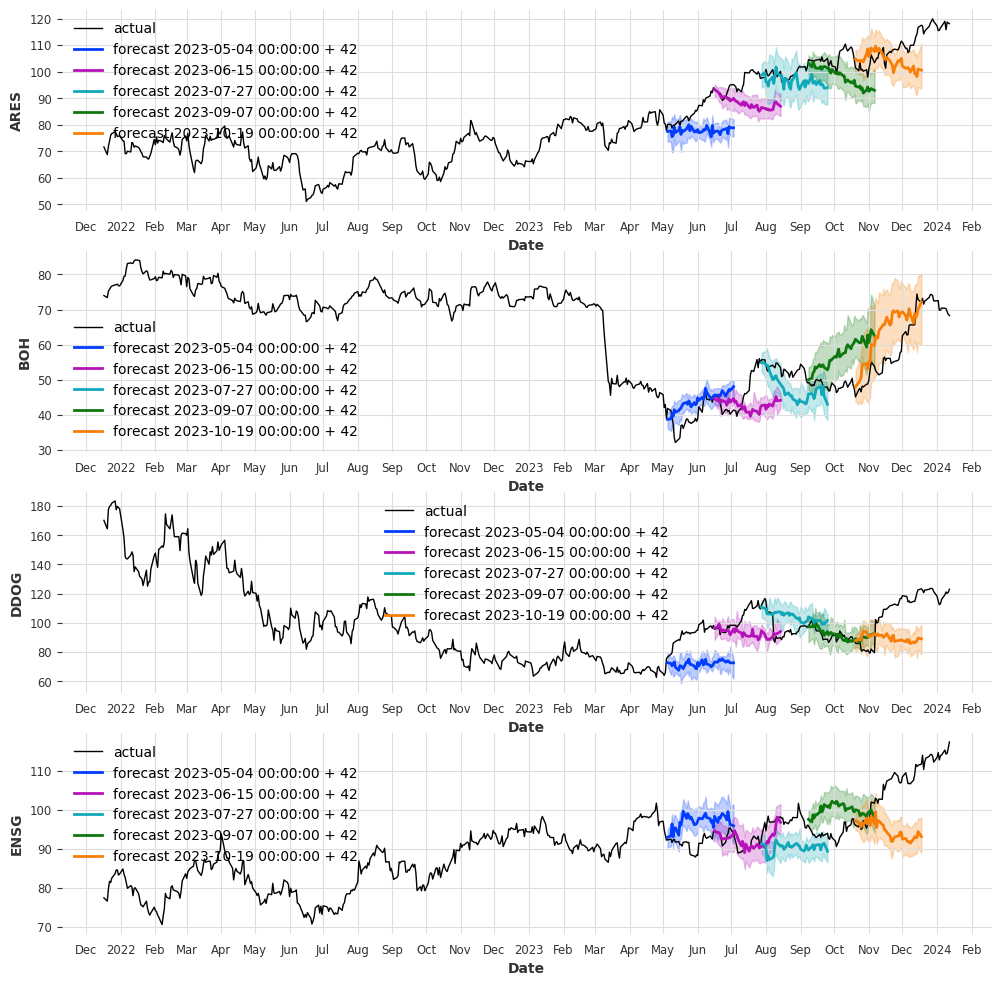

In [ ]:
import matplotlib.dates as mdates

# select a reasonable range of train and val data points for convenient visualization of results
actual = {}

fig, axes = plt.subplots(nrows=n_plot_samples, ncols=1, figsize=(12, 12))


def get_pred_list(pred_start=None):
    pred_list = []
    for t, target in sorted(target_series.items()):
        pred_series = target.slice(target.start_time(), pred_start-pd.Timedelta(days=1))
        pred_list.append(pred_series)
    return pred_list


def get_past_covs(start=None):
    past_cov_list = []
    for t, past_cov in sorted(past_covariates.items()):
        past_covs_sliced = past_cov.slice(past_cov.start_time(), pred_start-pd.Timedelta(days=1))
        past_cov_list.append(past_covs_sliced)
    return past_cov_list


def plot_pred(pred_list=None, past_cov_list=None):
    #pred2 = model.predict(pred_horizon, series=pred2_series, past_covariates=past_covariates, future_covariates=future_covariates, mc_dropout=True, num_samples=500) #   len(val)) 
    pred = model.predict(pred_horizon, series=pred_list, mc_dropout=True, num_samples=500, past_covariates=past_cov_list, future_covariates=future_cov_list)
    for i,t in enumerate(sorted(train_series.keys())):
        if i < n_plot_samples:
            # tsliced = target_series[t]
            # actual[t] = tsliced.slice(val_start-pd.Timedelta(days=train_history), target.end_time())
            # ax = actual[t].plot(label='actual', ax=axes[i])
            ax = pred[i].plot(label=f'forecast {pred_list[0].end_time()} + {pred_horizon}', linewidth=2, ax=axes[i])
            #pred2.plot(label=f'forecast {pred2_series.end_time()} + {pred_horizon}')
            plt.legend()
            # Major ticks every half year, minor ticks every month,
            ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(13)))
            ax.xaxis.set_minor_locator(mdates.MonthLocator())
            ax.grid(True)
            ax.set_ylabel(f'{t}')


def plot_actual():
    for i,t in enumerate(sorted(train_series.keys())):
        if i < n_plot_samples:
            tsliced = target_series[t]
            actual[t] = tsliced.slice(val_start-pd.Timedelta(days=train_history), target.end_time())
            ax = actual[t].plot(label='actual', linewidth=1, ax=axes[i])

plot_actual()

# show predictions at several points in time over the validation set
for w in range(5):
    pred_start = val_start + pd.Timedelta(days=w*pred_horizon)
    pred_list = get_pred_list(pred_start)
    past_cov_list = get_past_covs(pred_start)
    # print(f'pred_list: \n{pred_list}')
    plot_pred(pred_list=pred_list, past_cov_list=past_cov_list)



### Backtest Model


In [ ]:
# Backtest model on the full range of test data
from darts.metrics import rmse

def eval_model(model=None, series=None, start=None, past_covariates=None, future_covariates=None, forecast_horizon=None):
    # Past and future covariates are optional because they won't always be used in our tests
    
    # We backtest the model on the val portion of the flow series, with a forecast_horizon:
    backtest = model.historical_forecasts(series=series, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          start=start, 
                                          retrain=False,
                                          verbose=True, 
                                          forecast_horizon=forecast_horizon,
                                          overlap_end=True,
                                          num_samples=500, # probabilistic forecasting
                                          predict_kwargs={'mc_dropout': True, 'num_loader_workers': 10, 'n_jobs': -1}
                                          )
    
    return backtest


In [ ]:
# set the forecast start at a time before the validation date in order to see 
# the difference between predicting on training vs validation data
# predicting up to the validate date should be near match to actuals
# whereas predicting on unseen validate data should have room for improvement
forecast_start = val_start-pd.Timedelta(days=120)
forecast_horizon = pred_horizon # pred_horizon

backtest = eval_model(model=model, series=targets_list[:n_plot_samples], start=forecast_start, forecast_horizon=forecast_horizon, past_covariates=past_cov_list[:n_plot_samples], future_covariates=future_cov_list[:n_plot_samples])


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


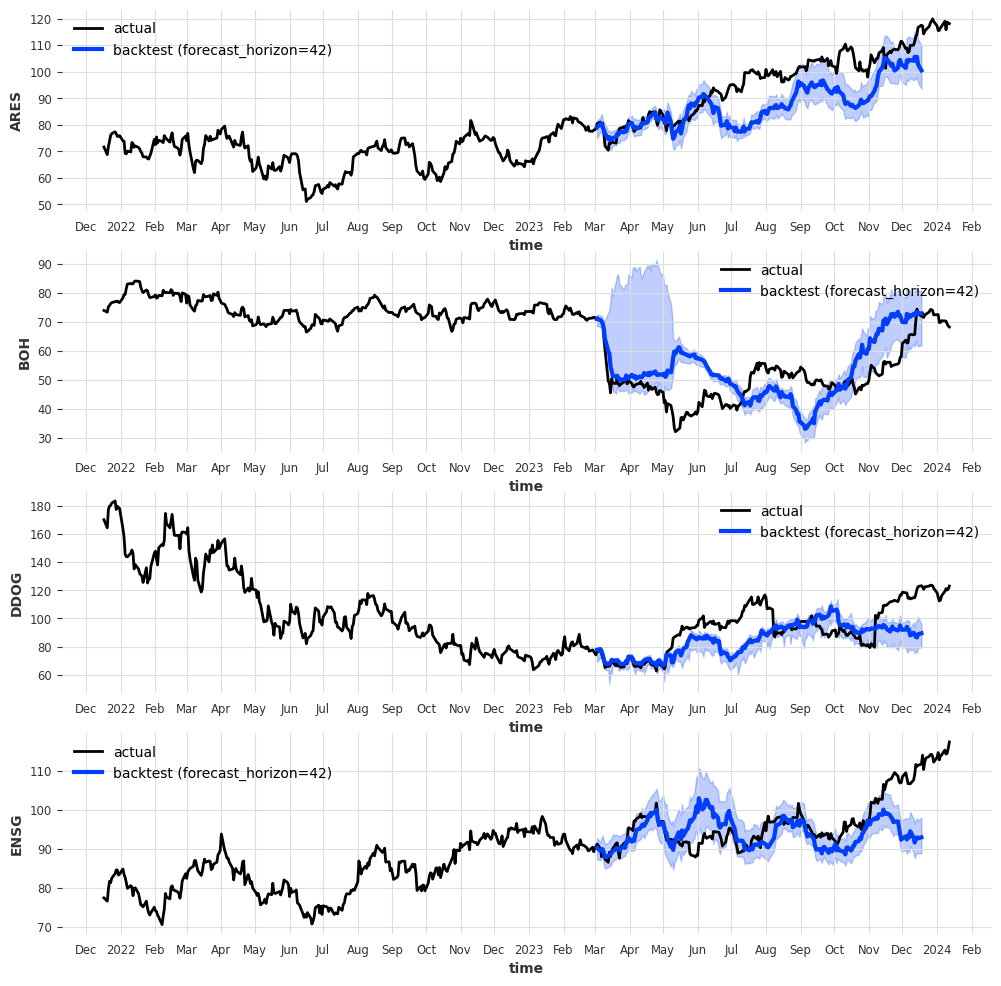

In [ ]:

fig, axes = plt.subplots(nrows=n_plot_samples, ncols=1, figsize=(12, 12))

for i,t in enumerate(sorted(train_series.keys())):
    if i < n_plot_samples:
        tsliced = target_series[t]
        actual[t] = tsliced.slice(val_start-pd.Timedelta(days=train_history), target.end_time())
        ax = actual[t].plot(label='actual', ax=axes[i])
        backtest[i].plot(label=f'backtest (forecast_horizon={forecast_horizon})', linewidth=3, ax=axes[i])
        plt.legend()

        # Major ticks every half year, minor ticks every month,
        ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(13)))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        ax.grid(True)
        ax.set_ylabel(f'{t}')



In [ ]:
print('Backtest RMSE = {}'.format(rmse(target_train_list[:n_plot_samples], backtest)))


Backtest RMSE = [1.654167535572437, 4.979944159549781, 1.9967524615311307, 1.7795701922768887]
